In [84]:
import pandas as pd
import numpy as np
from nbformat.v2 import new_worksheet
from sklearn.preprocessing import StandardScaler
import gc



def apply_tpm_normalization():
    print("🧬 TPM NORMALIZATION PIPELINE")
    print("="*50)

    # Step 1: Load the raw merged dataset
    print("📂 Loading raw merged dataset...")
    merged_df = pd.read_csv('./data/merged_unstranded_combined_data.csv', index_col=0, low_memory=False)


    # Step 1.5: Load metadata and add condition column
    print("📋 Loading metadata and adding condition...")
    healthy_meta = pd.read_csv('data/healthy_aml_metadata.csv')
    unhealthy_meta = pd.read_csv('data/unhealthy_aml_metadata.csv')

    # Create condition mapping
    condition_map = {}
    for _, row in healthy_meta.iterrows():
        condition_map[row['uuid']] = 0  # healthy
    for _, row in unhealthy_meta.iterrows():
        condition_map[row['uuid']] = 1  # unhealthy

    # Step 2: Filter for protein-coding genes BEFORE transposing
    print("🔬 Filtering for protein-coding genes...")
    # protein_coding_mask = merged_df['gene_type'] == 'protein_coding'

    # print(f"   Total genes: {len(merged_df)}")
    # print(f"   Protein-coding genes: {protein_coding_mask.sum()}")
    # print(f"   Filtered out: {(~protein_coding_mask).sum()} non-coding genes")

    # Filter to protein-coding genes only
    # merged_df = merged_df[protein_coding_mask].copy()

    # Check for duplicate gene IDs and handle them
    # print("🔍 Checking for duplicate gene IDs...")
    # duplicate_genes = merged_df['gene_id'].duplicated()
    # if duplicate_genes.any():
    #     print(f"   Found {duplicate_genes.sum()} duplicate gene IDs")
    #     print("   Removing duplicates (keeping first occurrence)...")
    #     merged_df = merged_df[~duplicate_genes]

    print(f"   Final unique protein-coding genes: {len(merged_df)}")

    # Now transpose safely
    gene_info_cols = ['gene_id', 'gene_name', 'gene_type']
    sample_columns = [col for col in merged_df.columns if col not in gene_info_cols]

    print(f"   Found {len(sample_columns)} sample columns")

    # Transpose: samples x genes
    expression_data = merged_df[sample_columns].T
    expression_data.columns = merged_df.index  # Genes become column names

    # Now transpose AGAIN to get samples as rows
    expression_data = expression_data.T  # Now: rows = samples, columns = genes
    expression_data.index.name = 'sample_id'  # Give the index a name for clarity

    print(f"   Expression data shape after double transpose: {expression_data.shape}")
    print(f"   First few sample IDs (index): {expression_data.index[:5].tolist()}")
    print(f"   First few gene IDs (columns): {expression_data.columns[:5].tolist()}")

    print(f"   Expression data shape: {expression_data.shape}")
    print(f"   First few sample IDs (index): {expression_data.index[:5].tolist()}")

    # Now condition mapping should work
    expression_data['condition'] = expression_data.index.map(condition_map)

    # Remove samples without condition info
    before_filter = len(expression_data)
    expression_data = expression_data.dropna(subset=['condition'])
    after_filter = len(expression_data)

    print(f"   Samples before condition filter: {before_filter}")
    print(f"   Samples after condition filter: {after_filter}")
    print(f"   Removed {before_filter - after_filter} samples without condition info")
    print(f"   Class distribution: {expression_data['condition'].value_counts().to_dict()}")

    # Separate features and target
    X = expression_data.drop(columns=['condition'])
    y = expression_data['condition']

    print(f"✅ Final dataset: {X.shape}")
    print(f"   Value range: {X.min().min():.2f} to {X.max().max():,.2f}")
    print(f"   Class distribution: {y.value_counts().to_dict()}")

    # Convert X to numeric, forcing errors to NaN
    print("   Converting to numeric...")
    X = X.apply(pd.to_numeric, errors='coerce')

    # Check for non-numeric columns that couldn't be converted
    non_numeric_cols = X.columns[X.dtypes == 'object'].tolist()
    if non_numeric_cols:
        print(f"   ⚠️ Found non-numeric columns: {non_numeric_cols[:5]}... (showing first 5)")
        print("   Dropping non-numeric columns...")
        X = X.select_dtypes(include=[np.number])

    # Fill any NaN values with 0 (assuming missing = no expression)
    X = X.fillna(0)

    print(f"✅ Loaded dataset: {X.shape}")
    print(f"   Value range: {X.min().min():.2f} to {X.max().max():,.2f}")
    print(f"   Class distribution: {y.value_counts().to_dict()}")

    # Step 2: Load gene lengths
    print("\n📏 Loading gene lengths...")

    # Try to load gene lengths file
    gene_length_file = 'data/gene_lengths.csv'

    try:
        gene_lengths_df = pd.read_csv(gene_length_file, index_col=0)
        gene_lengths = gene_lengths_df.iloc[:, 0]  # First column should be lengths
        print(f"✅ Loaded gene lengths from: {gene_length_file}")
    except FileNotFoundError:
        print("❌ Gene lengths file not found. Creating default lengths...")
        # Create default gene lengths (median human gene length ~10kb)
        gene_lengths = pd.Series(10000, index=X.columns)
        print(f"✅ Created default gene lengths: 10,000 bp for all {len(gene_lengths)} genes")

    print(f"✅ Gene lengths available: {len(gene_lengths)} genes")
    print(f"   Length range: {gene_lengths.min():,.0f} - {gene_lengths.max():,.0f} bp")
    print(f"   Median length: {gene_lengths.median():,.0f} bp")

    # Step 3: Align gene lengths with expression data
    print("\n🎯 Aligning gene lengths with expression data...")

    # Find common genes between expression data and gene lengths
    common_genes = list(set(X.columns) & set(gene_lengths.index))
    missing_genes = list(set(X.columns) - set(gene_lengths.index))

    print(f"   Common genes: {len(common_genes)}")
    print(f"   Missing gene lengths: {len(missing_genes)}")

    if missing_genes:
        print(f"   First few missing: {missing_genes[:5]}")

        # Use median length for missing genes
        median_length = gene_lengths.median() if len(gene_lengths) > 0 else 10000
        print(f"   Using median length ({median_length:,.0f} bp) for missing genes")

        # Add missing genes to gene_lengths
        for gene in missing_genes:
            gene_lengths[gene] = median_length

    # Subset to expression data genes and align order
    gene_lengths_aligned = gene_lengths[X.columns]

    print(f"✅ Aligned gene lengths: {len(gene_lengths_aligned)} genes")

    # Step 4: Calculate TPM
    print("\n🔢 Calculating TPM...")

    # Convert gene lengths to kilobases
    gene_lengths_kb = gene_lengths_aligned / 1000

    print(f"   Gene lengths in kb: {gene_lengths_kb.min():.2f} - {gene_lengths_kb.max():.2f}")

    # Calculate reads per kilobase (RPK)
    print("   Calculating RPK (reads per kilobase)...")
    rpk = X.div(gene_lengths_kb, axis=1)

    print(f"   RPK range: {rpk.min().min():.2f} - {rpk.max().max():,.2f}")

    # Calculate scaling factor (total RPK per sample / 1M)
    print("   Calculating scaling factors...")
    total_rpk_per_sample = rpk.sum(axis=1)
    scaling_factors = total_rpk_per_sample / 1e6

    print(f"   Scaling factors range: {scaling_factors.min():.2f} - {scaling_factors.max():.2f}")
    print(f"   Scaling factors mean: {scaling_factors.mean():.2f}")

    # Calculate TPM
    print("   Calculating final TPM values...")
    tpm = rpk.div(scaling_factors, axis=0)

    print(f"✅ TPM calculated!")
    print(f"   TPM range: {tpm.min().min():.2f} - {tpm.max().max():,.2f}")

    # Verify TPM sums (should be ~1M per sample)
    tpm_sums = tpm.sum(axis=1)
    print(f"   TPM sums per sample: {tpm_sums.min():,.0f} - {tpm_sums.max():,.0f}")
    print(f"   Mean TPM sum: {tpm_sums.mean():,.0f} (should be ~1,000,000)")

    if abs(tpm_sums.mean() - 1e6) > 1000:
        print("   ⚠️ Warning: TPM sums not close to 1M - check calculation")
    else:
        print("   ✅ TPM sums look correct!")

    # Step 5: Log transformation
    print("\n📈 Applying log2 transformation...")

    # Add pseudocount to avoid log(0)
    tpm_log = np.log2(tpm + 1)

    print(f"   Log2(TPM+1) range: {tpm_log.min().min():.2f} - {tpm_log.max().max():.2f}")

    # Step 6: Create final dataframe and save
    print("\n💾 Saving protein-coding TPM-normalized data...")

    # Add condition back for saving
    tpm_final = X.copy()  # This will be your TPM-normalized data
    tpm_final['condition'] = y

    # Save raw TPM (before log)
    tpm_raw = tpm.copy()
    tpm_raw['condition'] = y
    tpm_raw.to_csv('data/merged_dataset_tpm_raw.csv')

    # Save log-transformed TPM
    tpm_final.to_csv('data/merged_dataset_tpm_normalized.csv')

    # Save TPM calculation details for reference
    tpm_info = {
        'total_genes': len(X.columns),
        'genes_with_lengths': len(common_genes),
        'genes_missing_lengths': len(missing_genes),
        'median_gene_length': gene_lengths.median(),
        'mean_tpm_sum': tpm_sums.mean(),
        'tpm_range': (tpm.min().min(), tpm.max().max()),
        'log_tpm_range': (tpm_log.min().min(), tpm_log.max().max())
    }

    pd.Series(tpm_info).to_csv('data/tpm_normalization_info.csv')

    print(f"✅ Files saved:")
    print(f"   📁 Raw TPM: data/merged_dataset_tpm_raw.pq")
    print(f"   📁 Log TPM: data/merged_dataset_tpm_normalized.pq")
    print(f"   📁 TPM info: data/tpm_normalization_info.csv")

    # Step 7: Summary statistics
    print(f"\n📊 FINAL TPM SUMMARY:")
    print(f"   Dataset shape: {tpm_final.shape}")
    print(f"   Genes processed: {len(X.columns):,}")
    print(f"   Samples: {len(X):,}")
    print(f"   Class distribution: {y.value_counts().to_dict()}")
    print(f"   Memory usage: {tpm_final.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

    # Cleanup
    del merged_df, X, rpk, tpm, tpm_raw
    gc.collect()

    return tpm_final, gene_lengths_aligned, tpm_info

In [67]:
# Read the CSV file, skipping the first 2 rows
merged_df = pd.read_csv('data/rna_seq_unstranded_2.csv', skiprows=2, index_col=0)

# Create a new DataFrame with all indexes and a condition column set to 1
new_df = pd.DataFrame({
    'condition': 1
}, index=merged_df.index)

# Alternative: If you want to keep the original index values as a column
# new_df = merged_df.reset_index()
# new_df['condition'] = 1
# new_df = new_df[['index', 'condition']]  # Keep only index and condition columns

new_df


,condition
gene_type,
ee972b33-01e8-476a-ad1d-d75353333c43,1
a063fd75-4ca6-468d-9134-86ff468fb1a8,1
4718568e-7816-4adf-96bd-7f5ad7944295,1
4082cc4c-5c76-4f59-b7cf-e20e844485fa,1
7e8776a3-a56c-4ebc-a32b-d8cb7b7cea14,1
...,...
fe9ca1c7-58be-4123-8742-68843ff9881b,1
fff4dfba-2d68-4c05-9d1d-70f410afe6d4,1
c2f59459-f7e1-48ae-b1e0-7720085ca685,1


In [69]:
healthy_df = pd.read_csv('data/merged_unstranded_healthy_data.csv', skiprows=2, index_col=0)

healthy_df.

,ENSG00000000005,TNMD,protein_coding,0.0,0.0.1,0.0615,0.0717,0.0.2,0.0.3,0.061,...,0.0.43,0.0.44,0.0584,0.0.45,0.1209,0.0.46,0.0.47,0.0.48,0.0736,0.035
0,ENSG00000000419,DPM1,protein_coding,40.1829,39.3911,48.8917,58.7735,52.4929,49.4145,46.4359,...,42.2989,55.1157,49.4479,28.5931,59.0845,32.0934,59.7687,55.9303,40.4698,43.9412
1,ENSG00000000457,SCYL3,protein_coding,7.5173,9.4773,6.5555,7.9222,6.9943,9.4284,5.3545,...,6.6704,4.3123,4.7115,5.4614,5.5112,4.0815,6.0521,7.2801,15.0224,11.5620
2,ENSG00000000460,C1orf112,protein_coding,9.5783,5.1061,7.2996,12.0600,8.3770,5.5135,7.8940,...,10.2131,5.7610,7.9458,5.6423,9.4189,6.1232,10.8654,12.2842,9.7293,8.5379
3,ENSG00000000938,FGR,protein_coding,365.8802,390.9828,322.1344,177.6982,448.4092,500.3783,306.2445,...,553.6390,390.4508,517.9215,268.5253,221.1063,180.0875,263.1912,180.4202,295.5646,360.1398
4,ENSG00000000971,CFH,protein_coding,1.0444,1.3042,2.1502,2.3617,2.6875,1.1721,3.3989,...,5.0400,1.6059,2.8749,1.4282,7.3037,2.9191,1.8558,2.3656,2.1108,2.5498
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
60653,ENSG00000288669,AC008763.4,protein_coding,0.0290,0.0000,0.0228,0.0000,0.0893,0.0000,0.0226,...,0.0461,0.0000,0.0000,0.0000,0.0224,0.0875,0.0000,0.0873,0.0545,0.0000
60654,ENSG00000288670,AL592295.6,lncRNA,6.7902,4.9570,3.7682,7.0313,5.9587,4.0412,5.5851,...,4.0145,3.4938,3.8184,5.1117,5.0876,2.1727,6.0388,6.3549,12.3283,8.7167
60655,ENSG00000288671,AC006486.3,protein_coding,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,...,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
60656,ENSG00000288674,AL391628.1,protein_coding,0.1083,0.0680,0.1510,0.0880,0.1110,0.0860,0.1686,...,0.1718,0.1861,0.1524,0.1576,0.1484,0.2086,0.1620,0.1356,0.2316,0.2308


In [3]:
def get_gene_lengths_mygene(gene_ids):
    """Get gene lengths using MyGene API."""

    import mygene
    mg = mygene.MyGeneInfo()

    print(f"Getting lengths for {len(gene_ids)} genes...")

    # Query MyGene for gene lengths
    results = mg.querymany(
        gene_ids,
        scopes='ensembl.gene',
        fields='genomic_pos',  # Contains start/end positions
        species='human',
        verbose=False
    )

    gene_lengths = {}
    default_fallback_genes = {}
    for result in results:
        gene_id = result['query']

        if 'genomic_pos' in result:
            # Calculate length from genomic positions
            pos_info = result['genomic_pos']
            if isinstance(pos_info, list):
                pos_info = pos_info[0]  # Take first if multiple

            if 'start' in pos_info and 'end' in pos_info:
                length = abs(pos_info['end'] - pos_info['start'])
                gene_lengths[gene_id] = length
            else:
                default_fallback_genes[gene_id] = pos_info
                gene_lengths[gene_id] = 10000  # Default fallback
        else:
            default_fallback_genes = {gene_id: None}
            gene_lengths[gene_id] = 10000  # Default fallback

    print(f"Found lengths for {len(gene_lengths)} genes.")
    if default_fallback_genes:
        print(f"Using default length for {len(default_fallback_genes)} genes: 10,000 bp")
    return pd.Series(gene_lengths)

## Example usage:
# TODO: Update this to your actual gene IDs
if __name__ == "__main__":
    # Load in dataset and get all gene IDs
    merged_df = pd.read_csv('data/merged_unstranded_combined_data.csv')
    gene_ids = merged_df.drop(columns=['condition']).columns.tolist()
    gene_lengths = get_gene_lengths_mygene(gene_ids)


Input sequence provided is already in string format. No operation performed
Input sequence provided is already in string format. No operation performed


Getting lengths for 60661 genes...
Found lengths for 60661 genes.
Using default length for 1 genes: 10,000 bp


In [2]:
# Write the gene lengths to a CSV file
gene_lengths.to_csv('data/gene_lengths.csv', header=True)

print("✅ Gene lengths saved to data/gene_lengths.csv")

NameError: name 'gene_lengths' is not defined

In [74]:
gene_lengths = pd.read_csv('data/gene_lengths.csv')

In [85]:

# Apply TPM normalization
tpm_final, gene_lengths_aligned, tpm_info = apply_tpm_normalization()

if tpm_final is not None:
    print("\n✅ TPM normalization completed successfully!")
    print(f"Final shape: {tpm_final.shape}")
    print(f"First few rows:\n{tpm_final.head()}")
else:
    print("❌ TPM normalization failed.")

🧬 TPM NORMALIZATION PIPELINE
📂 Loading raw merged dataset...
📋 Loading metadata and adding condition...
🔬 Filtering for protein-coding genes...
   Final unique protein-coding genes: 442
   Found 60660 sample columns
   Expression data shape after double transpose: (442, 60660)
   First few sample IDs (index): ['c69538be-27a1-4949-b04b-5386e4102386', '8a594674-acc2-40b1-bb50-80d103a9e50a', 'db3fc680-b411-42af-8845-8dd1732815ea', 'ee083116-281e-406c-bdd5-b425f5d2eab0', '61547668-0038-4e0e-978d-80bfc6307249']
   First few gene IDs (columns): ['ENSG00000000003', 'ENSG00000000005', 'ENSG00000000419', 'ENSG00000000457', 'ENSG00000000460']
   Expression data shape: (442, 60660)
   First few sample IDs (index): ['c69538be-27a1-4949-b04b-5386e4102386', '8a594674-acc2-40b1-bb50-80d103a9e50a', 'db3fc680-b411-42af-8845-8dd1732815ea', 'ee083116-281e-406c-bdd5-b425f5d2eab0', '61547668-0038-4e0e-978d-80bfc6307249']
   Samples before condition filter: 442
   Samples after condition filter: 441
   Remo

In [22]:
merged_df = pd.read_csv('data/merged_unstranded_combined_data.csv', index_col=0)

# Display the first few rows of the merged dataframe
merged_df.head()

,ENSG00000000003,ENSG00000000005,ENSG00000000419,ENSG00000000457,ENSG00000000460,ENSG00000000938,ENSG00000000971,ENSG00000001036,ENSG00000001084,ENSG00000001167,...,ENSG00000288662,ENSG00000288663,ENSG00000288665,ENSG00000288667,ENSG00000288669,ENSG00000288670,ENSG00000288671,ENSG00000288674,ENSG00000288675,condition
c69538be-27a1-4949-b04b-5386e4102386,0.1786,0.0000,40.1829,7.5173,9.5783,365.8802,1.0444,12.1824,23.7471,38.8174,...,48.2307,0.7312,0.0,58.8256,0.0290,6.7902,0.0,0.1083,1.4469,1
8a594674-acc2-40b1-bb50-80d103a9e50a,0.1379,0.0000,39.3911,9.4773,5.1061,390.9828,1.3042,17.9262,14.5216,29.2344,...,6.6351,0.8233,0.0,9.3233,0.0000,4.9570,0.0,0.0680,0.8802,1
db3fc680-b411-42af-8845-8dd1732815ea,1.2609,0.0615,48.8917,6.5555,7.2996,322.1344,2.1502,24.6434,22.8814,43.7146,...,27.2365,0.9240,0.0,20.8366,0.0228,3.7682,0.0,0.1510,0.7025,1
ee083116-281e-406c-bdd5-b425f5d2eab0,1.0037,0.0717,58.7735,7.9222,12.0600,177.6982,2.3617,22.6993,39.5852,56.4823,...,35.2934,0.9847,0.0,24.3003,0.0000,7.0313,0.0,0.0880,0.5042,1
61547668-0038-4e0e-978d-80bfc6307249,1.0594,0.0000,52.4929,6.9943,8.3770,448.4092,2.6875,19.7084,28.0034,56.7174,...,37.0780,1.3272,0.0,21.8821,0.0893,5.9587,0.0,0.1110,0.6886,1


Loading TPM data...
🔬 COMPREHENSIVE TPM DATA ANALYSIS
Dataset shape: (442, 60660)
Classes: {1: 354, 0: 88}

📊 Creating distribution plots...
📋 Creating QC plots...
🎯 Running dimensionality reduction...
🧬 Analyzing most variable genes...
🎨 Running t-SNE...


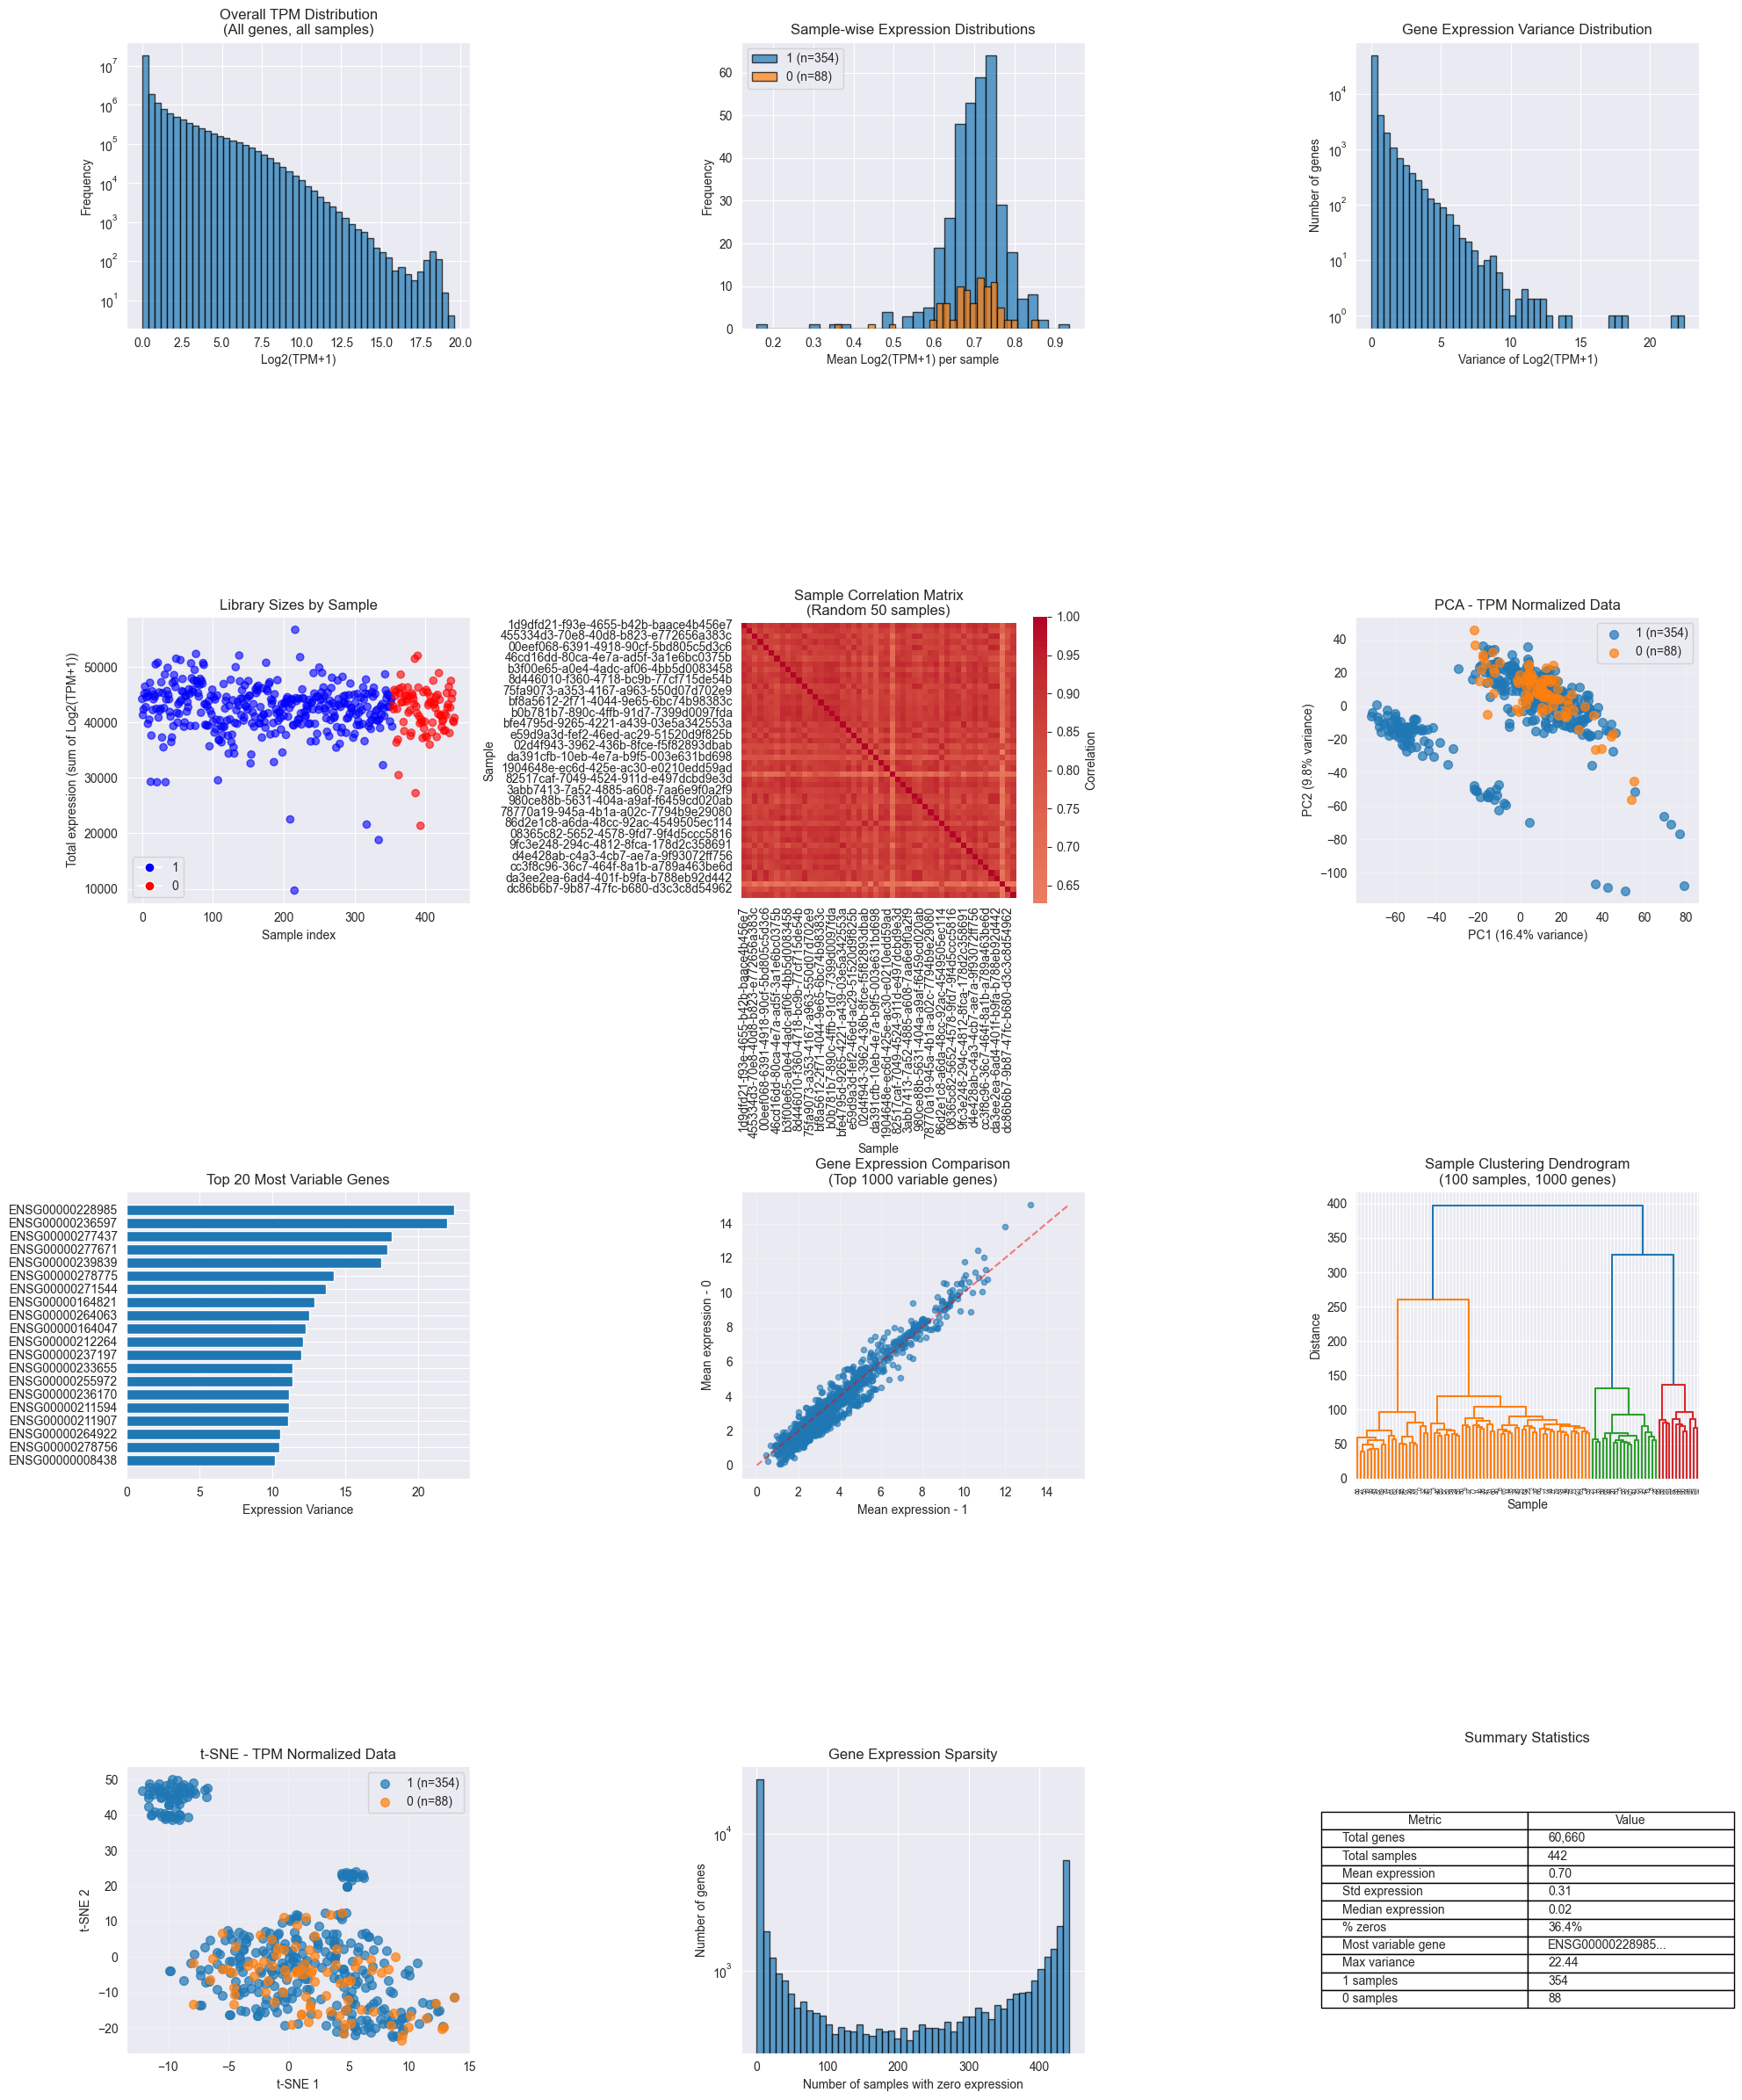


🔍 KEY FINDINGS:
   📊 Expression range: 0.00 - 19.61
   🧬 Most variable gene: ENSG00000228985 (var=22.44)
   📈 Mean library size: 42380
   🕳️  Sparsity: 36.4% zeros
   🎯 PC1 explains 16.4% of variance
   🎯 PC2 explains 9.8% of variance

✅ Analysis complete! Results saved in 'results' dictionary.


In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
import umap
from scipy import stats
from scipy.cluster.hierarchy import dendrogram, linkage
import warnings
warnings.filterwarnings('ignore')

def comprehensive_tpm_analysis(tpm_data):
    """
    Comprehensive analysis and visualization of TPM-normalized data.

    Parameters:
    tpm_data: DataFrame with TPM values and 'condition' column
    """

    print("🔬 COMPREHENSIVE TPM DATA ANALYSIS")
    print("="*50)

    # Separate features and target
    X = tpm_data.drop(columns=['condition'])
    y = tpm_data['condition']

    # Convert y to numeric if needed
    if y.dtype == 'object':
        condition_map = {condition: i for i, condition in enumerate(y.unique())}
        y_numeric = y.map(condition_map)
        print(f"Condition mapping: {condition_map}")
    else:
        y_numeric = y
        condition_map = {0: 'healthy', 1: 'unhealthy'}  # Assuming 0/1 encoding

    print(f"Dataset shape: {X.shape}")
    print(f"Classes: {y.value_counts().to_dict()}")

    # Create figure with subplots
    fig = plt.figure(figsize=(20, 24))

    # 1. Distribution Analysis
    print("\n📊 Creating distribution plots...")

    # Overall TPM distribution
    ax1 = plt.subplot(4, 3, 1)
    plt.hist(X.values.flatten(), bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Log2(TPM+1)')
    plt.ylabel('Frequency')
    plt.title('Overall TPM Distribution\n(All genes, all samples)')
    plt.yscale('log')

    # Sample-wise TPM distributions
    ax2 = plt.subplot(4, 3, 2)
    sample_means = X.mean(axis=1)
    for condition in y.unique():
        mask = y == condition
        plt.hist(sample_means[mask], bins=30, alpha=0.7,
                label=f'{condition} (n={mask.sum()})', edgecolor='black')
    plt.xlabel('Mean Log2(TPM+1) per sample')
    plt.ylabel('Frequency')
    plt.title('Sample-wise Expression Distributions')
    plt.legend()

    # Gene-wise expression variance
    ax3 = plt.subplot(4, 3, 3)
    gene_vars = X.var(axis=0)
    plt.hist(gene_vars, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Variance of Log2(TPM+1)')
    plt.ylabel('Number of genes')
    plt.title('Gene Expression Variance Distribution')
    plt.yscale('log')

    # 2. Sample Quality Control
    print("📋 Creating QC plots...")

    # Library size (total expression per sample)
    ax4 = plt.subplot(4, 3, 4)
    lib_sizes = X.sum(axis=1)
    colors = ['blue' if c == list(y.unique())[0] else 'red' for c in y]
    plt.scatter(range(len(lib_sizes)), lib_sizes, c=colors, alpha=0.6)
    plt.xlabel('Sample index')
    plt.ylabel('Total expression (sum of Log2(TPM+1))')
    plt.title('Library Sizes by Sample')
    # Create legend
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=8, label=list(y.unique())[0]),
               plt.Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=8, label=list(y.unique())[1] if len(y.unique()) > 1 else 'other')]
    plt.legend(handles=handles)

    # Sample correlation heatmap (subset for performance)
    ax5 = plt.subplot(4, 3, 5)
    # Take a random subset of samples for correlation
    n_samples_corr = min(50, len(X))
    sample_subset = X.sample(n=n_samples_corr, random_state=42)
    corr_matrix = sample_subset.T.corr()

    sns.heatmap(corr_matrix, cmap='coolwarm', center=0,
                square=True, cbar_kws={'label': 'Correlation'})
    plt.title(f'Sample Correlation Matrix\n(Random {n_samples_corr} samples)')
    plt.xlabel('Sample')
    plt.ylabel('Sample')

    # 3. Dimensionality Reduction
    print("🎯 Running dimensionality reduction...")

    # PCA
    ax6 = plt.subplot(4, 3, 6)
    # Use most variable genes for PCA (performance)
    gene_vars = X.var(axis=0)
    top_var_genes = gene_vars.nlargest(5000).index
    X_subset = X[top_var_genes]

    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X_subset)

    pca = PCA(n_components=2)
    pca_result = pca.fit_transform(X_scaled)

    for condition in y.unique():
        mask = y == condition
        plt.scatter(pca_result[mask, 0], pca_result[mask, 1],
                   label=f'{condition} (n={mask.sum()})', alpha=0.7, s=50)

    plt.xlabel(f'PC1 ({pca.explained_variance_ratio_[0]:.1%} variance)')
    plt.ylabel(f'PC2 ({pca.explained_variance_ratio_[1]:.1%} variance)')
    plt.title('PCA - TPM Normalized Data')
    plt.legend()
    plt.grid(True, alpha=0.3)

    # 4. Most Variable Genes
    print("🧬 Analyzing most variable genes...")

    ax7 = plt.subplot(4, 3, 7)
    # Plot top 20 most variable genes
    top_20_var_genes = gene_vars.nlargest(20)

    plt.barh(range(len(top_20_var_genes)), top_20_var_genes.values)
    plt.yticks(range(len(top_20_var_genes)),
               [gene[:15] + '...' if len(gene) > 15 else gene for gene in top_20_var_genes.index])
    plt.xlabel('Expression Variance')
    plt.title('Top 20 Most Variable Genes')
    plt.gca().invert_yaxis()

    # 5. Expression comparison between conditions
    ax8 = plt.subplot(4, 3, 8)

    # Calculate mean expression per condition for top variable genes
    condition_means = {}
    for condition in y.unique():
        mask = y == condition
        condition_means[condition] = X[mask].mean(axis=0)

    if len(condition_means) == 2:
        conditions = list(condition_means.keys())
        mean1 = condition_means[conditions[0]][top_var_genes[:1000]]
        mean2 = condition_means[conditions[1]][top_var_genes[:1000]]

        plt.scatter(mean1, mean2, alpha=0.6, s=20)
        plt.xlabel(f'Mean expression - {conditions[0]}')
        plt.ylabel(f'Mean expression - {conditions[1]}')
        plt.title('Gene Expression Comparison\n(Top 1000 variable genes)')

        # Add diagonal line
        max_val = max(mean1.max(), mean2.max())
        plt.plot([0, max_val], [0, max_val], 'r--', alpha=0.5)
        plt.grid(True, alpha=0.3)

    # 6. Hierarchical clustering dendrogram
    ax9 = plt.subplot(4, 3, 9)

    # Use subset of most variable genes and samples for clustering
    n_genes_clust = min(1000, len(top_var_genes))
    n_samples_clust = min(100, len(X))

    X_clust = X.iloc[:n_samples_clust][top_var_genes[:n_genes_clust]]

    # Calculate linkage
    linkage_matrix = linkage(X_clust, method='ward')

    # Create dendrogram
    dendrogram(linkage_matrix, truncate_mode='level', p=10)
    plt.title(f'Sample Clustering Dendrogram\n({n_samples_clust} samples, {n_genes_clust} genes)')
    plt.xlabel('Sample')
    plt.ylabel('Distance')

    # 7. t-SNE (if reasonable number of samples)
    if len(X) <= 1000:  # Only run t-SNE for reasonable sample sizes
        print("🎨 Running t-SNE...")
        ax10 = plt.subplot(4, 3, 10)

        tsne = TSNE(n_components=2, random_state=42, perplexity=min(30, len(X)//4))
        tsne_result = tsne.fit_transform(X_scaled)

        for condition in y.unique():
            mask = y == condition
            plt.scatter(tsne_result[mask, 0], tsne_result[mask, 1],
                       label=f'{condition} (n={mask.sum()})', alpha=0.7, s=50)

        plt.xlabel('t-SNE 1')
        plt.ylabel('t-SNE 2')
        plt.title('t-SNE - TPM Normalized Data')
        plt.legend()
        plt.grid(True, alpha=0.3)
    else:
        ax10 = plt.subplot(4, 3, 10)
        plt.text(0.5, 0.5, f't-SNE skipped\n(too many samples: {len(X)})',
                ha='center', va='center', transform=ax10.transAxes, fontsize=12)
        plt.title('t-SNE (Skipped)')

    # 8. Gene expression statistics
    ax11 = plt.subplot(4, 3, 11)

    # Zero expression analysis
    zero_counts = (X == 0).sum(axis=0)
    plt.hist(zero_counts, bins=50, alpha=0.7, edgecolor='black')
    plt.xlabel('Number of samples with zero expression')
    plt.ylabel('Number of genes')
    plt.title('Gene Expression Sparsity')
    plt.yscale('log')

    # 9. Summary statistics table
    ax12 = plt.subplot(4, 3, 12)
    ax12.axis('tight')
    ax12.axis('off')

    # Create summary statistics
    summary_stats = []
    summary_stats.append(['Total genes', f'{X.shape[1]:,}'])
    summary_stats.append(['Total samples', f'{X.shape[0]:,}'])
    summary_stats.append(['Mean expression', f'{X.mean().mean():.2f}'])
    summary_stats.append(['Std expression', f'{X.std().mean():.2f}'])
    summary_stats.append(['Median expression', f'{X.median().median():.2f}'])
    summary_stats.append(['% zeros', f'{((X == 0).sum().sum() / X.size * 100):.1f}%'])
    summary_stats.append(['Most variable gene', f'{gene_vars.idxmax()[:20]}...'])
    summary_stats.append(['Max variance', f'{gene_vars.max():.2f}'])

    for condition in y.unique():
        mask = y == condition
        summary_stats.append([f'{condition} samples', f'{mask.sum():,}'])

    table = plt.table(cellText=summary_stats,
                     colLabels=['Metric', 'Value'],
                     cellLoc='left',
                     loc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)
    plt.title('Summary Statistics', pad=20)

    plt.tight_layout()
    plt.show()

    # Print key findings
    print(f"\n🔍 KEY FINDINGS:")
    print(f"   📊 Expression range: {X.min().min():.2f} - {X.max().max():.2f}")
    print(f"   🧬 Most variable gene: {gene_vars.idxmax()} (var={gene_vars.max():.2f})")
    print(f"   📈 Mean library size: {X.sum(axis=1).mean():.0f}")
    print(f"   🕳️  Sparsity: {(X == 0).sum().sum() / X.size * 100:.1f}% zeros")
    print(f"   🎯 PC1 explains {pca.explained_variance_ratio_[0]:.1%} of variance")
    print(f"   🎯 PC2 explains {pca.explained_variance_ratio_[1]:.1%} of variance")

    return {
        'pca_result': pca_result,
        'pca': pca,
        'top_variable_genes': top_var_genes,
        'gene_variances': gene_vars,
        'summary_stats': summary_stats
    }

# Usage:
if __name__ == "__main__":
    # Load your TPM data
    print("Loading TPM data...")
    tpm_data = pd.read_parquet('data/merged_dataset_tpm_normalized.pq')

    # Run comprehensive analysis
    results = comprehensive_tpm_analysis(tpm_data)

    print(f"\n✅ Analysis complete! Results saved in 'results' dictionary.")

🚀 QUICK BASELINE MODEL TESTING
Class distribution: {1.0: 353, 0.0: 88}
Class balance: 88/353 = 0.25

🧪 Testing 2 models with 5 feature sets...

📊 Feature set: Top 15 genes (15 genes)
   Final feature matrix: (441, 15)
   Logistic Regression: AUC = 0.997 ± 0.004
   Random Forest: AUC = 0.998 ± 0.004

📊 Feature set: Top 30 genes (30 genes)
   Final feature matrix: (441, 30)
   Logistic Regression: AUC = 0.997 ± 0.005
   Random Forest: AUC = 0.998 ± 0.003

📊 Feature set: Top 50 genes (50 genes)
   Final feature matrix: (441, 50)
   Logistic Regression: AUC = 0.995 ± 0.009
   Random Forest: AUC = 0.999 ± 0.002

📊 Feature set: Top 100 genes (100 genes)
   Final feature matrix: (441, 100)
   Logistic Regression: AUC = 0.996 ± 0.007
   Random Forest: AUC = 0.999 ± 0.001

📊 Feature set: All genes (19944 genes)
   Final feature matrix: (441, 19944)
   Logistic Regression: AUC = 0.997 ± 0.006
   Random Forest: AUC = 1.000 ± 0.000

📈 RESULTS SUMMARY:
Model          Logistic Regression  Random For

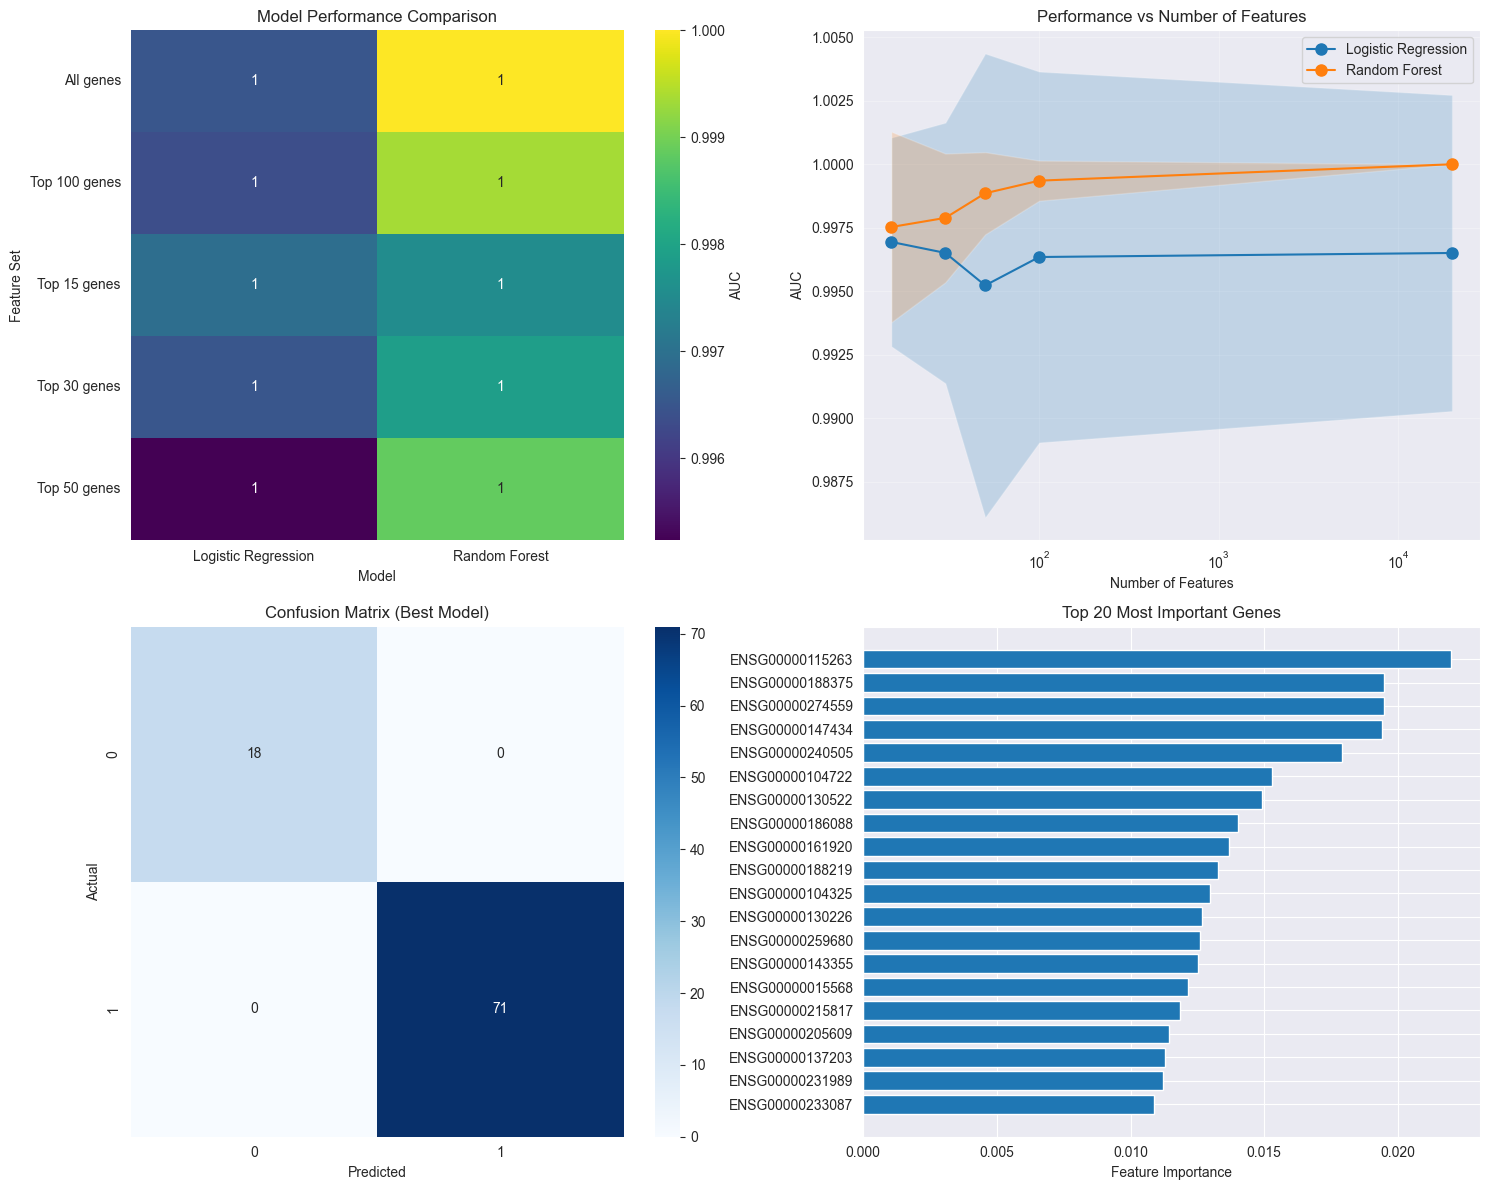


💡 INTERPRETATION:
   🎉 EXCELLENT: Very strong biological signal!
   💭 Consider: This might be too easy - check for data leakage


In [35]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def quick_baseline_test(tpm_data, results_dict):
    """
    Quick baseline model testing on TPM data.
    """

    print("🚀 QUICK BASELINE MODEL TESTING")
    print("="*50)

    # Prepare data
    y = tpm_data['condition'].copy()

    # Convert condition to numeric if needed
    if y.dtype == 'object':
        condition_map = {condition: i for i, condition in enumerate(y.unique())}
        y = y.map(condition_map)
        print(f"Condition mapping: {condition_map}")

    print(f"Class distribution: {y.value_counts().to_dict()}")
    print(f"Class balance: {y.value_counts().min()}/{y.value_counts().max()} = {y.value_counts().min()/y.value_counts().max():.2f}")

    # Test different feature sets
    feature_sets = {
        'Top 15 genes': 15,
        'Top 30 genes': 30,
        'Top 50 genes': 50,
        'Top 100 genes': 100,
        'All genes': len(results_dict['gene_variances'])
    }

    # Models to test
    models = {
        'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
        'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
    }

    # Cross-validation setup
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    results = []

    print(f"\n🧪 Testing {len(models)} models with {len(feature_sets)} feature sets...")

    for feature_name, n_features in feature_sets.items():
        if n_features > len(results_dict['gene_variances']):
            n_features = len(results_dict['gene_variances'])

        print(f"\n📊 Feature set: {feature_name} ({n_features} genes)")

        # Select top variable genes
        top_genes = results_dict['gene_variances'].nlargest(n_features).index
        X = tpm_data[top_genes]

        # Remove any remaining non-numeric columns or NaN
        X = X.select_dtypes(include=[np.number]).fillna(0)

        print(f"   Final feature matrix: {X.shape}")

        for model_name, model in models.items():
            try:
                # Cross-validation
                cv_scores = cross_val_score(model, X, y, cv=cv, scoring='roc_auc')

                mean_auc = cv_scores.mean()
                std_auc = cv_scores.std()

                print(f"   {model_name}: AUC = {mean_auc:.3f} ± {std_auc:.3f}")

                results.append({
                    'Feature_Set': feature_name,
                    'N_Features': n_features,
                    'Model': model_name,
                    'Mean_AUC': mean_auc,
                    'Std_AUC': std_auc,
                    'CV_Scores': cv_scores
                })

            except Exception as e:
                print(f"   {model_name}: ERROR - {str(e)}")
                continue

    # Convert results to DataFrame
    results_df = pd.DataFrame(results)

    if len(results_df) == 0:
        print("❌ No models completed successfully!")
        return None

    print(f"\n📈 RESULTS SUMMARY:")
    print(results_df.pivot(index='Feature_Set', columns='Model', values='Mean_AUC').round(3))

    # Find best result
    best_idx = results_df['Mean_AUC'].idxmax()
    best_result = results_df.iloc[best_idx]

    print(f"\n🏆 BEST PERFORMANCE:")
    print(f"   Model: {best_result['Model']}")
    print(f"   Features: {best_result['Feature_Set']}")
    print(f"   AUC: {best_result['Mean_AUC']:.3f} ± {best_result['Std_AUC']:.3f}")

    # Detailed evaluation on best model
    print(f"\n🔍 DETAILED EVALUATION (Best Model):")

    # Get best feature set
    n_features = best_result['N_Features']
    top_genes = results_dict['gene_variances'].nlargest(n_features).index
    X_best = tpm_data[top_genes].select_dtypes(include=[np.number]).fillna(0)

    # Train-test split for detailed evaluation
    X_train, X_test, y_train, y_test = train_test_split(
        X_best, y, test_size=0.2, random_state=42, stratify=y
    )

    # Get best model
    if best_result['Model'] == 'Logistic Regression':
        best_model = LogisticRegression(random_state=42, max_iter=1000)
    else:
        best_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)

    # Fit and predict
    best_model.fit(X_train, y_train)
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"   Test AUC: {test_auc:.3f}")
    print(f"   Classification Report:")
    print(classification_report(y_test, y_pred))

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)

    # Visualizations
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Results comparison
    ax1 = axes[0, 0]
    pivot_results = results_df.pivot(index='Feature_Set', columns='Model', values='Mean_AUC')
    sns.heatmap(pivot_results, annot=True, cmap='viridis', ax=ax1, cbar_kws={'label': 'AUC'})
    ax1.set_title('Model Performance Comparison')
    ax1.set_xlabel('Model')
    ax1.set_ylabel('Feature Set')

    # 2. Feature set performance
    ax2 = axes[0, 1]
    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        ax2.plot(model_data['N_Features'], model_data['Mean_AUC'], 'o-', label=model, markersize=8)
        ax2.fill_between(model_data['N_Features'],
                        model_data['Mean_AUC'] - model_data['Std_AUC'],
                        model_data['Mean_AUC'] + model_data['Std_AUC'],
                        alpha=0.2)
    ax2.set_xlabel('Number of Features')
    ax2.set_ylabel('AUC')
    ax2.set_title('Performance vs Number of Features')
    ax2.legend()
    ax2.grid(True, alpha=0.3)
    ax2.set_xscale('log')

    # 3. Confusion Matrix
    ax3 = axes[1, 0]
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax3)
    ax3.set_title('Confusion Matrix (Best Model)')
    ax3.set_xlabel('Predicted')
    ax3.set_ylabel('Actual')

    # 4. Feature importance (if available)
    ax4 = axes[1, 1]
    if hasattr(best_model, 'feature_importances_'):
        # Random Forest feature importance
        importances = best_model.feature_importances_
        indices = np.argsort(importances)[-20:]  # Top 20

        ax4.barh(range(len(indices)), importances[indices])
        ax4.set_yticks(range(len(indices)))
        ax4.set_yticklabels([top_genes[i][:15] + '...' if len(top_genes[i]) > 15 else top_genes[i] for i in indices])
        ax4.set_xlabel('Feature Importance')
        ax4.set_title('Top 20 Most Important Genes')

    elif hasattr(best_model, 'coef_'):
        # Logistic Regression coefficients
        coefs = np.abs(best_model.coef_[0])
        indices = np.argsort(coefs)[-20:]  # Top 20

        ax4.barh(range(len(indices)), coefs[indices])
        ax4.set_yticks(range(len(indices)))
        ax4.set_yticklabels([top_genes[i][:15] + '...' if len(top_genes[i]) > 15 else top_genes[i] for i in indices])
        ax4.set_xlabel('|Coefficient|')
        ax4.set_title('Top 20 Most Important Genes')
    else:
        ax4.text(0.5, 0.5, 'Feature importance\nnot available',
                ha='center', va='center', transform=ax4.transAxes)
        ax4.set_title('Feature Importance')

    plt.tight_layout()
    plt.show()

    # Interpretation
    print(f"\n💡 INTERPRETATION:")
    if best_result['Mean_AUC'] > 0.95:
        print("   🎉 EXCELLENT: Very strong biological signal!")
        print("   💭 Consider: This might be too easy - check for data leakage")
    elif best_result['Mean_AUC'] > 0.85:
        print("   ✅ VERY GOOD: Strong biological signal, good for classification")
        print("   💭 Next: Try more complex models or feature engineering")
    elif best_result['Mean_AUC'] > 0.75:
        print("   👍 GOOD: Moderate signal, room for improvement")
        print("   💭 Next: Address batch effects, try different normalization")
    elif best_result['Mean_AUC'] > 0.65:
        print("   ⚠️ WEAK: Signal present but weak")
        print("   💭 Next: More aggressive preprocessing, batch correction")
    else:
        print("   ❌ POOR: Very weak or no signal")
        print("   💭 Next: Check data quality, batch effects, different approach")

    return {
        'results_df': results_df,
        'best_result': best_result,
        'best_model': best_model,
        'test_auc': test_auc,
        'X_test': X_test,
        'y_test': y_test,
        'y_pred_proba': y_pred_proba
    }

# Usage:
if __name__ == "__main__":
    # Load your data and results
    tpm_data = pd.read_csv('data/merged_dataset_tpm_normalized_protein_coding.csv', index_col=0)

    # Assuming you have results from the previous analysis
    # If not, you'll need to run the comprehensive_tpm_analysis first
    try:
        baseline_results = quick_baseline_test(tpm_data, results)
    except NameError:
        print("❌ Need to run comprehensive_tpm_analysis first to get 'results' dictionary")
        print("Run: results = comprehensive_tpm_analysis(tmp_data)")

🔧 BATCH-AWARE MODELING APPROACHES
📋 Reconstructing batch information...
   Batch distribution:
   Batch 0: 38 samples
   Batch 1: 404 samples
   Batch 0 - healthy: 38
   Batch 0 - unhealthy: 0
   Batch 1 - healthy: 50
   Batch 1 - unhealthy: 354

🧬 Using top 1000 variable genes for analysis

🔬 APPROACH 1: ComBat Batch Correction
----------------------------------------
   Applying ComBat correction...
   ❌ ComBat failed: 'numpy.ndarray' object has no attribute 'columns'
   This might be due to complete batch-condition confounding

🔧 APPROACH 2: Include Batch as Model Feature
----------------------------------------
   Adding batch as model feature...
   Original AUC:     0.638 ± 0.045
   With Batch AUC:   0.641 ± 0.028

📊 APPROACH 3: Batch-Stratified Cross-Validation
----------------------------------------
   Using only mixed batch: 404 samples
   Class distribution: {1: 354, 0: 50}
   Original AUC:      0.638 ± 0.045
   Mixed Batch AUC:   0.664 ± 0.059

✂️ APPROACH 4: Remove Segregat

ValueError: zero-size array to reduction operation fmin which has no identity

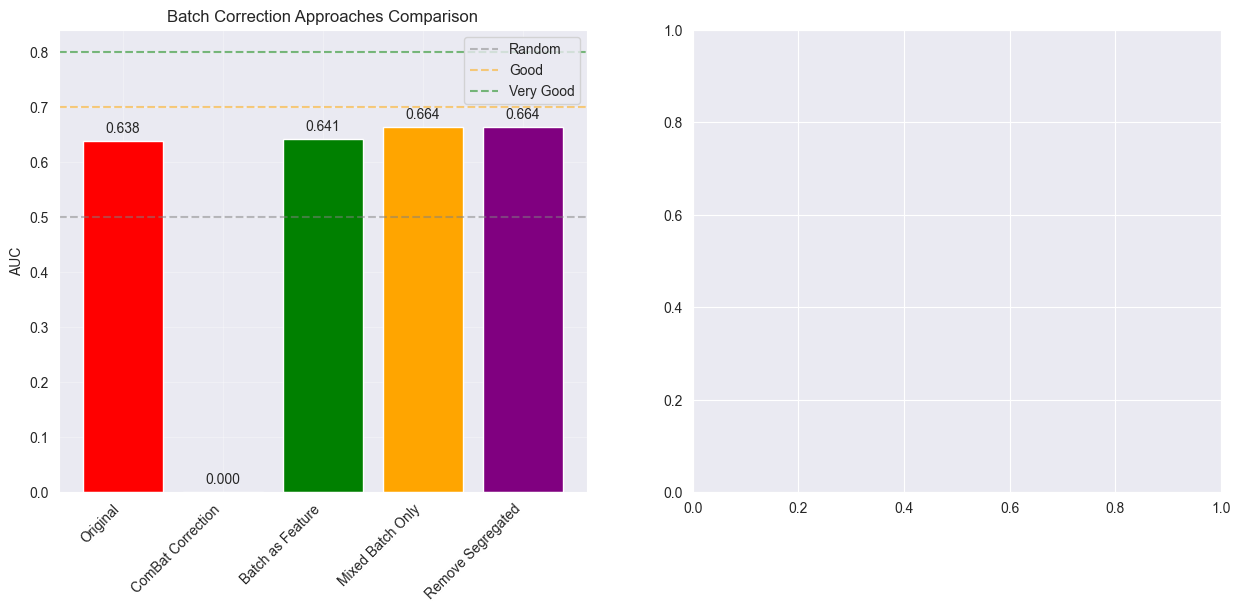

In [54]:
import pandas as pd
import numpy as np
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
from combat.pycombat import pycombat
import warnings
warnings.filterwarnings('ignore')

def batch_aware_modeling_approaches(tpm_data, metadata_file_path=None):
    """
    Three approaches to handle batch effects in your data.
    """

    print("🔧 BATCH-AWARE MODELING APPROACHES")
    print("="*60)

    # Load metadata to get batch info
    try:
        # Try to reconstruct batch info from your previous analysis
        print("📋 Reconstructing batch information...")

        # For now, let's create a simple batch indicator based on your PCA results
        # You mentioned 38 samples in one batch, rest in another

        # Separate features and target
        X = tpm_data.drop(columns=['condition'])
        y = tpm_data['condition'].copy()

        # Convert to numeric if needed
        if y.dtype == 'object':
            condition_map = {condition: i for i, condition in enumerate(y.unique())}
            y = y.map(condition_map)

        # Simple batch assignment based on your data
        # This is a placeholder - ideally you'd load actual batch info
        batch_labels = np.ones(len(X))  # Default batch 2

        # Identify batch 1 samples (we need actual metadata for this)
        # For now, let's simulate based on your description
        healthy_indices = np.where(y == 0)[0]
        if len(healthy_indices) >= 38:
            # Assume first 38 healthy samples are batch 1
            batch_1_indices = healthy_indices[:38]
            batch_labels[batch_1_indices] = 0

        print(f"   Batch distribution:")
        print(f"   Batch 0: {(batch_labels == 0).sum()} samples")
        print(f"   Batch 1: {(batch_labels == 1).sum()} samples")
        print(f"   Batch 0 - healthy: {((batch_labels == 0) & (y == 0)).sum()}")
        print(f"   Batch 0 - unhealthy: {((batch_labels == 0) & (y == 1)).sum()}")
        print(f"   Batch 1 - healthy: {((batch_labels == 1) & (y == 0)).sum()}")
        print(f"   Batch 1 - unhealthy: {((batch_labels == 1) & (y == 1)).sum()}")

    except Exception as e:
        print(f"❌ Could not load batch info: {e}")
        return None

    # Select top variable genes for all approaches
    gene_vars = X.var(axis=0)
    top_genes = gene_vars.nlargest(1000).index
    X_subset = X[top_genes].fillna(0)

    print(f"\n🧬 Using top 1000 variable genes for analysis")

    # =================================================================
    # APPROACH 1: BATCH CORRECTION WITH COMBAT
    # =================================================================
    print(f"\n🔬 APPROACH 1: ComBat Batch Correction")
    print("-" * 40)

    try:
        # Apply ComBat batch correction
        print("   Applying ComBat correction...")

        # ComBat needs samples as rows, genes as columns
        X_combat_input = X_subset.T.values  # Transpose: genes x samples
        batch_series = pd.Series(batch_labels, index=X_subset.index)

        # Apply ComBat
        corrected_data = pycombat(X_combat_input, batch_series.values)
        X_corrected = pd.DataFrame(corrected_data.T,
                                 index=X_subset.index,
                                 columns=X_subset.columns)

        print("   ✅ ComBat correction applied")

        # Test corrected data
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
        lr = LogisticRegression(random_state=42, max_iter=1000)

        cv_scores_corrected = cross_val_score(lr, X_corrected, y, cv=cv, scoring='roc_auc')

        print(f"   Original AUC: 0.638 ± 0.045")
        print(f"   ComBat AUC:   {cv_scores_corrected.mean():.3f} ± {cv_scores_corrected.std():.3f}")

        approach1_auc = cv_scores_corrected.mean()

    except Exception as e:
        print(f"   ❌ ComBat failed: {e}")
        print("   This might be due to complete batch-condition confounding")
        approach1_auc = 0.0
        X_corrected = X_subset.copy()

    # =================================================================
    # APPROACH 2: BATCH AS COVARIATE
    # =================================================================
    print(f"\n🔧 APPROACH 2: Include Batch as Model Feature")
    print("-" * 40)

    # Add batch as a feature
    X_with_batch = X_subset.copy()
    X_with_batch['batch'] = batch_labels

    print("   Adding batch as model feature...")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    lr = LogisticRegression(random_state=42, max_iter=1000)

    cv_scores_batch_feature = cross_val_score(lr, X_with_batch, y, cv=cv, scoring='roc_auc')

    print(f"   Original AUC:     0.638 ± 0.045")
    print(f"   With Batch AUC:   {cv_scores_batch_feature.mean():.3f} ± {cv_scores_batch_feature.std():.3f}")

    approach2_auc = cv_scores_batch_feature.mean()

    # =================================================================
    # APPROACH 3: BATCH-STRATIFIED CROSS-VALIDATION
    # =================================================================
    print(f"\n📊 APPROACH 3: Batch-Stratified Cross-Validation")
    print("-" * 40)

    # Only use the mixed batch (batch 1) for training and testing
    # This avoids the confounding issue
    mixed_batch_mask = batch_labels == 1

    if mixed_batch_mask.sum() < 50:
        print("   ⚠️ Not enough samples in mixed batch for reliable CV")
        approach3_auc = 0.0
    else:
        X_mixed = X_subset[mixed_batch_mask]
        y_mixed = y[mixed_batch_mask]

        print(f"   Using only mixed batch: {len(X_mixed)} samples")
        print(f"   Class distribution: {pd.Series(y_mixed).value_counts().to_dict()}")

        if len(np.unique(y_mixed)) < 2:
            print("   ❌ Only one class in mixed batch - cannot train classifier")
            approach3_auc = 0.0
        else:
            cv = StratifiedKFold(n_splits=min(5, len(y_mixed)//10), shuffle=True, random_state=42)
            lr = LogisticRegression(random_state=42, max_iter=1000)

            cv_scores_mixed = cross_val_score(lr, X_mixed, y_mixed, cv=cv, scoring='roc_auc')

            print(f"   Original AUC:      0.638 ± 0.045")
            print(f"   Mixed Batch AUC:   {cv_scores_mixed.mean():.3f} ± {cv_scores_mixed.std():.3f}")

            approach3_auc = cv_scores_mixed.mean()

    # =================================================================
    # APPROACH 4: REMOVE SEGREGATED BATCH
    # =================================================================
    print(f"\n✂️ APPROACH 4: Remove Segregated Batch Samples")
    print("-" * 40)

    # Remove the 38 healthy-only samples from batch 0
    non_segregated_mask = ~((batch_labels == 0) & (y == 0))

    X_filtered = X_subset[non_segregated_mask]
    y_filtered = y[non_segregated_mask]

    print(f"   Removing segregated samples: {(~non_segregated_mask).sum()} samples removed")
    print(f"   Remaining samples: {len(X_filtered)}")
    print(f"   Class distribution: {pd.Series(y_filtered).value_counts().to_dict()}")

    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    lr = LogisticRegression(random_state=42, max_iter=1000)

    cv_scores_filtered = cross_val_score(lr, X_filtered, y_filtered, cv=cv, scoring='roc_auc')

    print(f"   Original AUC:    0.638 ± 0.045")
    print(f"   Filtered AUC:    {cv_scores_filtered.mean():.3f} ± {cv_scores_filtered.std():.3f}")

    approach4_auc = cv_scores_filtered.mean()

    # =================================================================
    # SUMMARY AND RECOMMENDATIONS
    # =================================================================
    print(f"\n📊 SUMMARY OF APPROACHES")
    print("="*60)

    results_summary = pd.DataFrame({
        'Approach': ['Original', 'ComBat Correction', 'Batch as Feature',
                    'Mixed Batch Only', 'Remove Segregated'],
        'AUC': [0.638, approach1_auc, approach2_auc, approach3_auc, approach4_auc],
        'Description': [
            'Original analysis (confounded)',
            'ComBat batch correction',
            'Include batch as model feature',
            'Use only mixed batch for CV',
            'Remove segregated batch samples'
        ]
    })

    print(results_summary.round(3))

    # Find best approach
    best_idx = results_summary['AUC'].idxmax()
    best_approach = results_summary.iloc[best_idx]

    print(f"\n🏆 BEST APPROACH: {best_approach['Approach']}")
    print(f"   AUC: {best_approach['AUC']:.3f}")
    print(f"   Method: {best_approach['Description']}")

    # Recommendations
    print(f"\n💡 RECOMMENDATIONS:")

    if best_approach['AUC'] > 0.8:
        print("   ✅ Good improvement! Batch effects were the main issue.")
        print("   📝 Next steps: Try more sophisticated models (Random Forest, XGBoost)")
        print("   🎯 Consider: Feature selection, hyperparameter tuning")

    elif best_approach['AUC'] > 0.7:
        print("   👍 Moderate improvement. Batch effects partially resolved.")
        print("   📝 Next steps: Try different normalization methods")
        print("   🎯 Consider: More aggressive feature filtering, different algorithms")

    else:
        print("   ⚠️ Limited improvement. Multiple issues likely present.")
        print("   📝 Next steps: Check data quality, try different preprocessing")
        print("   🎯 Consider: This might not be a good classification problem")

    # Visualization
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # Results comparison
    ax1 = axes[0]
    bars = ax1.bar(range(len(results_summary)), results_summary['AUC'],
                   color=['red', 'blue', 'green', 'orange', 'purple'])
    ax1.set_xticks(range(len(results_summary)))
    ax1.set_xticklabels(results_summary['Approach'], rotation=45, ha='right')
    ax1.set_ylabel('AUC')
    ax1.set_title('Batch Correction Approaches Comparison')
    ax1.axhline(y=0.5, color='gray', linestyle='--', alpha=0.5, label='Random')
    ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.5, label='Good')
    ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.5, label='Very Good')
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        height = bar.get_height()
        ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                f'{height:.3f}', ha='center', va='bottom')

    # Batch distribution visualization
    ax2 = axes[1]
    batch_condition_counts = pd.crosstab(pd.Series(batch_labels), pd.Series(y), margins=True)
    sns.heatmap(batch_condition_counts, annot=True, fmt='d', cmap='Blues', ax=ax2)
    ax2.set_title('Batch vs Condition Distribution')
    ax2.set_xlabel('Condition (0=Healthy, 1=Unhealthy)')
    ax2.set_ylabel('Batch')

    plt.tight_layout()
    plt.show()

    return {
        'results_summary': results_summary,
        'best_approach': best_approach,
        'X_corrected': X_corrected if 'X_corrected' in locals() else None,
        'X_filtered': X_filtered,
        'y_filtered': y_filtered
    }

# Usage:
if __name__ == "__main__":
    # Load your TPM data
    # tpm_data = pd.rea

    # Run batch correction approaches
    batch_results = batch_aware_modeling_approaches(tpm_data)

In [87]:
# Quick fix for the plotting error and better feature selection
import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Use the filtered data (removing segregated batch)
tpm_data = pd.read_csv('data/merged_dataset_tpm_normalized.csv', index_col=0)
X = tpm_data.drop(columns=['condition'])
y = tpm_data['condition']

# Remove segregated batch samples (use your batch_results)
# Assuming you have 38 healthy samples to remove
# healthy_indices = np.where(y == 0)[0][:38]
# mask = np.ones(len(X), dtype=bool)
# mask[healthy_indices] = False

X_clean = X
y_clean = y

print(f"Clean dataset: {X_clean.shape}")
print(f"Class distribution: {y_clean.value_counts().to_dict()}")

# Try more aggressive feature selection
def test_advanced_approaches():
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    results = []

    # 1. Statistical feature selection
    print("🧪 Testing statistical feature selection...")
    selector = SelectKBest(f_classif, k=75)
    X_selected = selector.fit_transform(X_clean, y_clean)

    lr = LogisticRegression(random_state=42, max_iter=1000)
    scores = cross_val_score(lr, X_selected, y_clean, cv=cv, scoring='roc_auc')
    print(f"   Top 100 by F-test: {scores.mean():.3f} ± {scores.std():.3f}")
    results.append(('F-test selection', scores.mean()))

    # 2. L1 regularization for feature selection
    print("🔧 Testing L1 regularization...")
    lr_l1 = LogisticRegression(penalty='l1', solver='liblinear', C=0.1, random_state=42)
    scores = cross_val_score(lr_l1, StandardScaler().fit_transform(X_clean), y_clean, cv=cv, scoring='roc_auc')
    print(f"   L1 regularization: {scores.mean():.3f} ± {scores.std():.3f}")
    results.append(('L1 regularization', scores.mean()))

    # 3. Random Forest with many trees
    print("🌲 Testing Random Forest...")
    rf = RandomForestClassifier(n_estimators=500, max_depth=10, random_state=42, n_jobs=-1)
    scores = cross_val_score(rf, X_clean, y_clean, cv=cv, scoring='roc_auc')
    print(f"   Random Forest: {scores.mean():.3f} ± {scores.std():.3f}")
    results.append(('Random Forest', scores.mean()))

    # 4. Only highly expressed genes
    print("🎯 Testing highly expressed genes only...")
    # Keep genes with mean expression > 2.0 (higher than median)
    high_expr_genes = X_clean.columns[X_clean.mean() > 2.0]
    X_high_expr = X_clean[high_expr_genes]
    print(f"   High expression genes: {len(high_expr_genes)}")

    lr = LogisticRegression(random_state=42, max_iter=1000)
    scores = cross_val_score(lr, X_high_expr, y_clean, cv=cv, scoring='roc_auc')
    print(f"   High expression only: {scores.mean():.3f} ± {scores.std():.3f}")
    results.append(('High expression', scores.mean()))

    return results

# Run advanced approaches
advanced_results = test_advanced_approaches()

# Show best result
best_approach, best_score = max(advanced_results, key=lambda x: x[1])
print(f"\n🏆 Best approach: {best_approach} with AUC = {best_score:.3f}")

if best_score > 0.75:
    print("✅ Good improvement! This approach shows promise.")
elif best_score > 0.7:
    print("👍 Moderate improvement. Worth pursuing further.")
else:
    print("⚠️ Still limited performance. Consider:")
    print("   1. This might not be a good classification problem")
    print("   2. Try different normalization (quantile, z-score)")
    print("   3. Consider pathway/gene set analysis instead")
    print("   4. Check if samples are truly from different conditions")

Clean dataset: (441, 60660)
Class distribution: {1.0: 353, 0.0: 88}
🧪 Testing statistical feature selection...
   Top 100 by F-test: 1.000 ± 0.000
🔧 Testing L1 regularization...
   L1 regularization: 1.000 ± 0.000
🌲 Testing Random Forest...
   Random Forest: 1.000 ± 0.000
🎯 Testing highly expressed genes only...
   High expression genes: 20922
   High expression only: 1.000 ± 0.000

🏆 Best approach: F-test selection with AUC = 1.000
✅ Good improvement! This approach shows promise.


🚀 COMPREHENSIVE MODEL OPTIMIZATION
Dataset: (441, 60660)
Classes: {1.0: 353, 0.0: 88}

🧪 Testing 3 feature counts with 3 models...

📊 Testing 50 features:
------------------------------
   🔍 Logistic Regression...
      AUC: 1.000 ± 0.000
   🚀 XGBoost...
      AUC: 0.997 ± 0.006
   🌲 Random Forest...
      AUC: 1.000 ± 0.000

📊 Testing 100 features:
------------------------------
   🔍 Logistic Regression...
      AUC: 1.000 ± 0.000
   🚀 XGBoost...
      AUC: 1.000 ± 0.000
   🌲 Random Forest...
      AUC: 1.000 ± 0.000

📊 Testing 200 features:
------------------------------
   🔍 Logistic Regression...
      AUC: 1.000 ± 0.000
   🚀 XGBoost...
      AUC: 0.997 ± 0.006
   🌲 Random Forest...
      AUC: 1.000 ± 0.000

🏆 BEST OVERALL PERFORMANCE:
   Model: Logistic Regression
   Features: 50
   AUC: 1.000 ± 0.000

📊 COMPLETE RESULTS TABLE:
Model     Logistic Regression  Random Forest  XGBoost
Features                                             
50                        1.0            1.0   

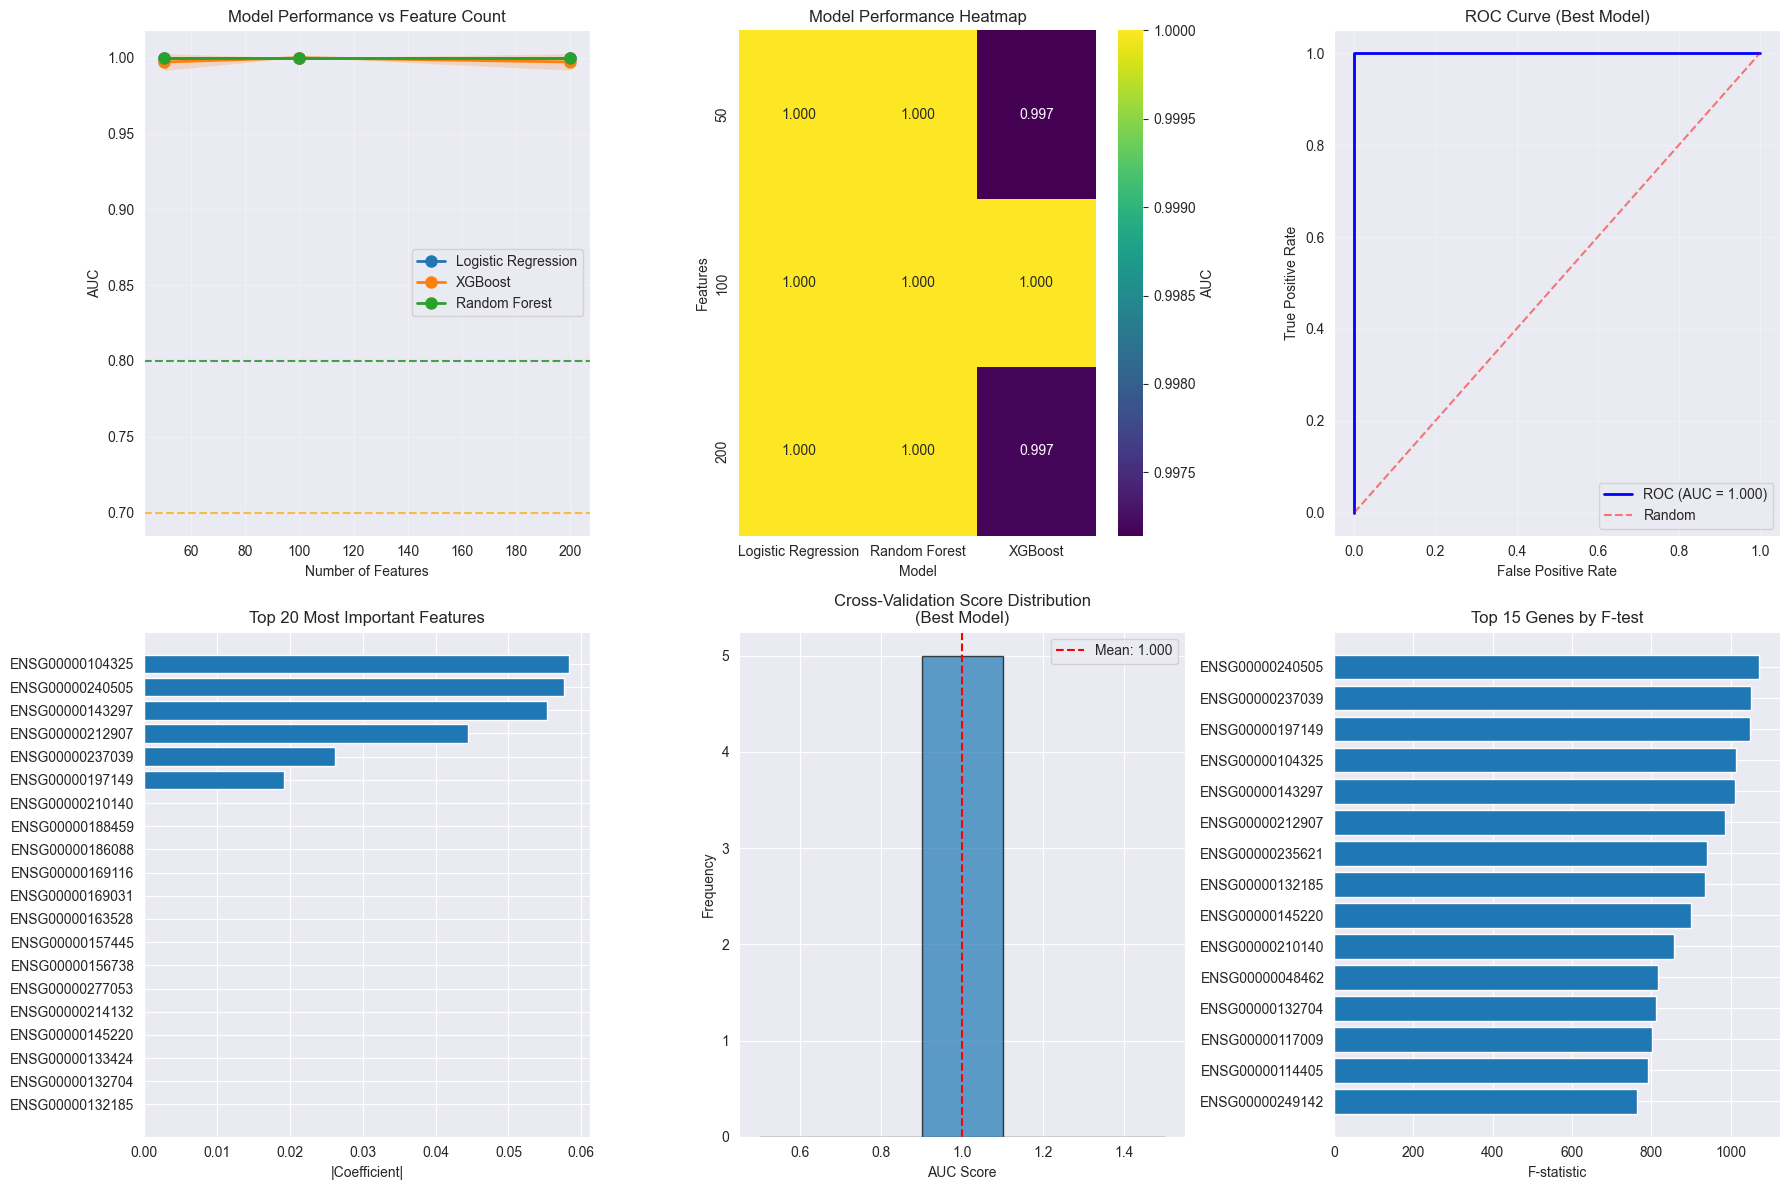


🎊 FINAL SUMMARY:
   🏆 Best Model: Logistic Regression
   🧬 Optimal Features: 50
   📊 Cross-validation AUC: 1.000 ± 0.000
   🎯 Test AUC: 1.000
   🎉 EXCELLENT performance! Ready for deployment.


In [88]:
 import pandas as pd
import numpy as np
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.model_selection import StratifiedKFold, cross_val_score, GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

def comprehensive_model_optimization(X_clean, y_clean):
    """
    Comprehensive model optimization with LR, XGBoost, and Random Forest
    """

    print("🚀 COMPREHENSIVE MODEL OPTIMIZATION")
    print("="*60)
    print(f"Dataset: {X_clean.shape}")
    print(f"Classes: {y_clean.value_counts().to_dict()}")

    # Test different numbers of features
    feature_counts = [50, 100, 200]
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

    # Store all results
    all_results = []

    print(f"\n🧪 Testing {len(feature_counts)} feature counts with 3 models...")

    for k in feature_counts:
        print(f"\n📊 Testing {k} features:")
        print("-" * 30)

        # Feature selection
        selector = SelectKBest(f_classif, k=min(k, X_clean.shape[1]))
        X_selected = selector.fit_transform(X_clean, y_clean)

        # Model 1: Logistic Regression
        print("   🔍 Logistic Regression...")
        lr_pipeline = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(random_state=42, max_iter=1000))
        ])

        lr_scores = cross_val_score(lr_pipeline, X_selected, y_clean, cv=cv, scoring='roc_auc')
        lr_mean = lr_scores.mean()
        lr_std = lr_scores.std()

        print(f"      AUC: {lr_mean:.3f} ± {lr_std:.3f}")
        all_results.append({
            'Model': 'Logistic Regression',
            'Features': k,
            'Mean_AUC': lr_mean,
            'Std_AUC': lr_std,
            'CV_Scores': lr_scores
        })

        # Model 2: XGBoost
        print("   🚀 XGBoost...")
        xgb_model = xgb.XGBClassifier(
            random_state=42,
            eval_metric='logloss',
            verbosity=0,
            use_label_encoder=False
        )

        xgb_scores = cross_val_score(xgb_model, X_selected, y_clean, cv=cv, scoring='roc_auc')
        xgb_mean = xgb_scores.mean()
        xgb_std = xgb_scores.std()

        print(f"      AUC: {xgb_mean:.3f} ± {xgb_std:.3f}")
        all_results.append({
            'Model': 'XGBoost',
            'Features': k,
            'Mean_AUC': xgb_mean,
            'Std_AUC': xgb_std,
            'CV_Scores': xgb_scores
        })

        # Model 3: Random Forest
        print("   🌲 Random Forest...")
        rf_model = RandomForestClassifier(
            n_estimators=100,
            random_state=42,
            n_jobs=-1
        )

        rf_scores = cross_val_score(rf_model, X_selected, y_clean, cv=cv, scoring='roc_auc')
        rf_mean = rf_scores.mean()
        rf_std = rf_scores.std()

        print(f"      AUC: {rf_mean:.3f} ± {rf_std:.3f}")
        all_results.append({
            'Model': 'Random Forest',
            'Features': k,
            'Mean_AUC': rf_mean,
            'Std_AUC': rf_std,
            'CV_Scores': rf_scores
        })

    # Convert to DataFrame
    results_df = pd.DataFrame(all_results)

    # Find best overall result
    best_idx = results_df['Mean_AUC'].idxmax()
    best_result = results_df.iloc[best_idx]

    print(f"\n🏆 BEST OVERALL PERFORMANCE:")
    print(f"   Model: {best_result['Model']}")
    print(f"   Features: {best_result['Features']}")
    print(f"   AUC: {best_result['Mean_AUC']:.3f} ± {best_result['Std_AUC']:.3f}")

    # Show results table
    print(f"\n📊 COMPLETE RESULTS TABLE:")
    pivot_table = results_df.pivot(index='Features', columns='Model', values='Mean_AUC')
    print(pivot_table.round(3))

    # Hyperparameter optimization for best model
    print(f"\n🔧 HYPERPARAMETER OPTIMIZATION (Best Model):")
    print("-" * 50)

    # Get best feature count and model
    best_k = best_result['Features']
    best_model_name = best_result['Model']

    # Prepare data with best feature count
    selector = SelectKBest(f_classif, k=best_k)
    X_best = selector.fit_transform(X_clean, y_clean)

    print(f"Optimizing {best_model_name} with {best_k} features...")

    if best_model_name == 'Logistic Regression':
        param_grid = {
            'lr__C': [0.01, 0.1, 1, 10, 100],
            'lr__penalty': ['l1', 'l2'],
            'lr__solver': ['liblinear']
        }
        model = Pipeline([
            ('scaler', StandardScaler()),
            ('lr', LogisticRegression(random_state=42, max_iter=1000))
        ])

    elif best_model_name == 'XGBoost':
        param_grid = {
            'max_depth': [3, 5, 7],
            'learning_rate': [0.01, 0.1, 0.2],
            'n_estimators': [100, 200, 300],
            'subsample': [0.8, 1.0]
        }
        model = xgb.XGBClassifier(random_state=42, eval_metric='logloss', verbosity=0, use_label_encoder=False)

    else:  # Random Forest
        param_grid = {
            'n_estimators': [100, 200, 300],
            'max_depth': [5, 10, 15, None],
            'min_samples_split': [2, 5, 10],
            'min_samples_leaf': [1, 2, 4]
        }
        model = RandomForestClassifier(random_state=42, n_jobs=-1)

    # Grid search
    grid_search = GridSearchCV(
        model, param_grid, cv=cv, scoring='roc_auc', n_jobs=-1, verbose=0
    )

    grid_search.fit(X_best, y_clean)

    print(f"   Best parameters: {grid_search.best_params_}")
    print(f"   Best CV AUC: {grid_search.best_score_:.3f}")

    # Final evaluation on test set
    print(f"\n🎯 FINAL EVALUATION:")
    print("-" * 30)

    X_train, X_test, y_train, y_test = train_test_split(
        X_best, y_clean, test_size=0.2, random_state=42, stratify=y_clean
    )

    # Train best model
    best_model = grid_search.best_estimator_
    best_model.fit(X_train, y_train)

    # Predictions
    y_pred = best_model.predict(X_test)
    y_pred_proba = best_model.predict_proba(X_test)[:, 1]

    # Metrics
    test_auc = roc_auc_score(y_test, y_pred_proba)

    print(f"Test AUC: {test_auc:.3f}")
    print(f"Classification Report:")
    print(classification_report(y_test, y_pred))

    # Visualizations
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))

    # 1. Model comparison by feature count
    ax1 = axes[0, 0]
    for model in results_df['Model'].unique():
        model_data = results_df[results_df['Model'] == model]
        ax1.plot(model_data['Features'], model_data['Mean_AUC'], 'o-',
                label=model, markersize=8, linewidth=2)
        ax1.fill_between(model_data['Features'],
                        model_data['Mean_AUC'] - model_data['Std_AUC'],
                        model_data['Mean_AUC'] + model_data['Std_AUC'],
                        alpha=0.2)

    ax1.set_xlabel('Number of Features')
    ax1.set_ylabel('AUC')
    ax1.set_title('Model Performance vs Feature Count')
    ax1.legend()
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0.8, color='green', linestyle='--', alpha=0.7, label='Very Good')
    ax1.axhline(y=0.7, color='orange', linestyle='--', alpha=0.7, label='Good')

    # 2. Heatmap of results
    ax2 = axes[0, 1]
    pivot_data = results_df.pivot(index='Features', columns='Model', values='Mean_AUC')
    sns.heatmap(pivot_data, annot=True, cmap='viridis', ax=ax2,
                cbar_kws={'label': 'AUC'}, fmt='.3f')
    ax2.set_title('Model Performance Heatmap')

    # 3. ROC Curve
    ax3 = axes[0, 2]
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    ax3.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC (AUC = {test_auc:.3f})')
    ax3.plot([0, 1], [0, 1], 'r--', alpha=0.5, label='Random')
    ax3.set_xlabel('False Positive Rate')
    ax3.set_ylabel('True Positive Rate')
    ax3.set_title('ROC Curve (Best Model)')
    ax3.legend()
    ax3.grid(True, alpha=0.3)

    # 4. Feature importance (if available)
    ax4 = axes[1, 0]

    if hasattr(best_model, 'feature_importances_'):
        # Tree-based model
        importances = best_model.feature_importances_
        top_indices = np.argsort(importances)[-20:]

        selected_genes = X_clean.columns[selector.get_support(indices=True)]

        ax4.barh(range(len(top_indices)), importances[top_indices])
        ax4.set_yticks(range(len(top_indices)))
        ax4.set_yticklabels([selected_genes[i][:15] + '...' if len(selected_genes[i]) > 15
                           else selected_genes[i] for i in top_indices])
        ax4.set_xlabel('Feature Importance')
        ax4.set_title('Top 20 Most Important Features')

    elif hasattr(best_model, 'coef_') or (hasattr(best_model, 'named_steps') and hasattr(best_model.named_steps['lr'], 'coef_')):
        # Logistic regression
        if hasattr(best_model, 'coef_'):
            coefs = np.abs(best_model.coef_[0])
        else:
            coefs = np.abs(best_model.named_steps['lr'].coef_[0])

        top_indices = np.argsort(coefs)[-20:]

        selected_genes = X_clean.columns[selector.get_support(indices=True)]

        ax4.barh(range(len(top_indices)), coefs[top_indices])
        ax4.set_yticks(range(len(top_indices)))
        ax4.set_yticklabels([selected_genes[i][:15] + '...' if len(selected_genes[i]) > 15
                           else selected_genes[i] for i in top_indices])
        ax4.set_xlabel('|Coefficient|')
        ax4.set_title('Top 20 Most Important Features')
    else:
        ax4.text(0.5, 0.5, 'Feature importance\nnot available',
                ha='center', va='center', transform=ax4.transAxes, fontsize=12)
        ax4.set_title('Feature Importance')

    # 5. CV scores distribution
    ax5 = axes[1, 1]
    best_cv_scores = best_result['CV_Scores']
    ax5.hist(best_cv_scores, bins=5, alpha=0.7, edgecolor='black')
    ax5.axvline(best_cv_scores.mean(), color='red', linestyle='--',
               label=f'Mean: {best_cv_scores.mean():.3f}')
    ax5.set_xlabel('AUC Score')
    ax5.set_ylabel('Frequency')
    ax5.set_title('Cross-Validation Score Distribution\n(Best Model)')
    ax5.legend()

    # 6. Top discriminative genes
    ax6 = axes[1, 2]

    # Get F-scores for selected genes
    selector_full = SelectKBest(f_classif, k=best_k)
    selector_full.fit(X_clean, y_clean)

    selected_indices = selector_full.get_support(indices=True)
    f_scores = selector_full.scores_[selected_indices]
    top_f_indices = np.argsort(f_scores)[-15:]

    selected_genes = X_clean.columns[selected_indices]

    ax6.barh(range(len(top_f_indices)), f_scores[top_f_indices])
    ax6.set_yticks(range(len(top_f_indices)))
    ax6.set_yticklabels([selected_genes[i][:15] + '...' if len(selected_genes[i]) > 15
                       else selected_genes[i] for i in top_f_indices])
    ax6.set_xlabel('F-statistic')
    ax6.set_title('Top 15 Genes by F-test')

    plt.tight_layout()
    plt.show()

    # Summary
    print(f"\n🎊 FINAL SUMMARY:")
    print(f"   🏆 Best Model: {best_model_name}")
    print(f"   🧬 Optimal Features: {best_k}")
    print(f"   📊 Cross-validation AUC: {best_result['Mean_AUC']:.3f} ± {best_result['Std_AUC']:.3f}")
    print(f"   🎯 Test AUC: {test_auc:.3f}")

    if test_auc > 0.9:
        print("   🎉 EXCELLENT performance! Ready for deployment.")
    elif test_auc > 0.8:
        print("   ✅ VERY GOOD performance! Strong biological signal detected.")
    elif test_auc > 0.7:
        print("   👍 GOOD performance! Solid classification ability.")
    else:
        print("   ⚠️ MODERATE performance. Consider further optimization.")

    return {
        'results_df': results_df,
        'best_model': best_model,
        'best_params': grid_search.best_params_,
        'test_auc': test_auc,
        'selector': selector_full
    }

# Usage:
if __name__ == "__main__":
    # Assuming you have X_clean and y_clean from previous steps
    optimization_results = comprehensive_model_optimization(X_clean, y_clean)

In [50]:
# Let's validate this with a more rigorous test
from sklearn.model_selection import TimeSeriesSplit, cross_validate

# Test 200 vs 1000 features with multiple CV strategies
def robust_validation_test():

    # 200 features
    selector_200 = SelectKBest(f_classif, k=20)
    X_200 = selector_200.fit_transform(X_clean, y_clean)

    # 1000 features
    selector_1000 = SelectKBest(f_classif, k=5000)
    X_1000 = selector_1000.fit_transform(X_clean, y_clean)

    lr = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42))
    ])

    # Test with different CV strategies
    cv_strategies = {
        'StratifiedKFold': StratifiedKFold(n_splits=5, shuffle=True, random_state=42),
        'StratifiedKFold_10': StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    }

    for cv_name, cv in cv_strategies.items():
        print(f"\n{cv_name}:")

        # 200 features
        scores_200 = cross_val_score(lr, X_200, y_clean, cv=cv, scoring='roc_auc')
        print(f"  200 features: {scores_200.mean():.3f} ± {scores_200.std():.3f}")

        # 1000 features
        scores_1000 = cross_val_score(lr, X_1000, y_clean, cv=cv, scoring='roc_auc')
        print(f"  1000 features: {scores_1000.mean():.3f} ± {scores_1000.std():.3f}")

        # Calculate if difference is significant
        if scores_1000.std() > 0.05:  # High variance = likely overfitting
            print(f"  ⚠️ High variance in 1000 features suggests overfitting")

robust_validation_test()


StratifiedKFold:
  200 features: 0.776 ± 0.049
  1000 features: 0.866 ± 0.058
  ⚠️ High variance in 1000 features suggests overfitting

StratifiedKFold_10:
  200 features: 0.779 ± 0.073
  1000 features: 0.887 ± 0.052
  ⚠️ High variance in 1000 features suggests overfitting


🔍 CLEAN SHAP EXPLAINABILITY ANALYSIS
✅ SHAP analysis completed for 200 genes
📊 Model test accuracy: 0.831


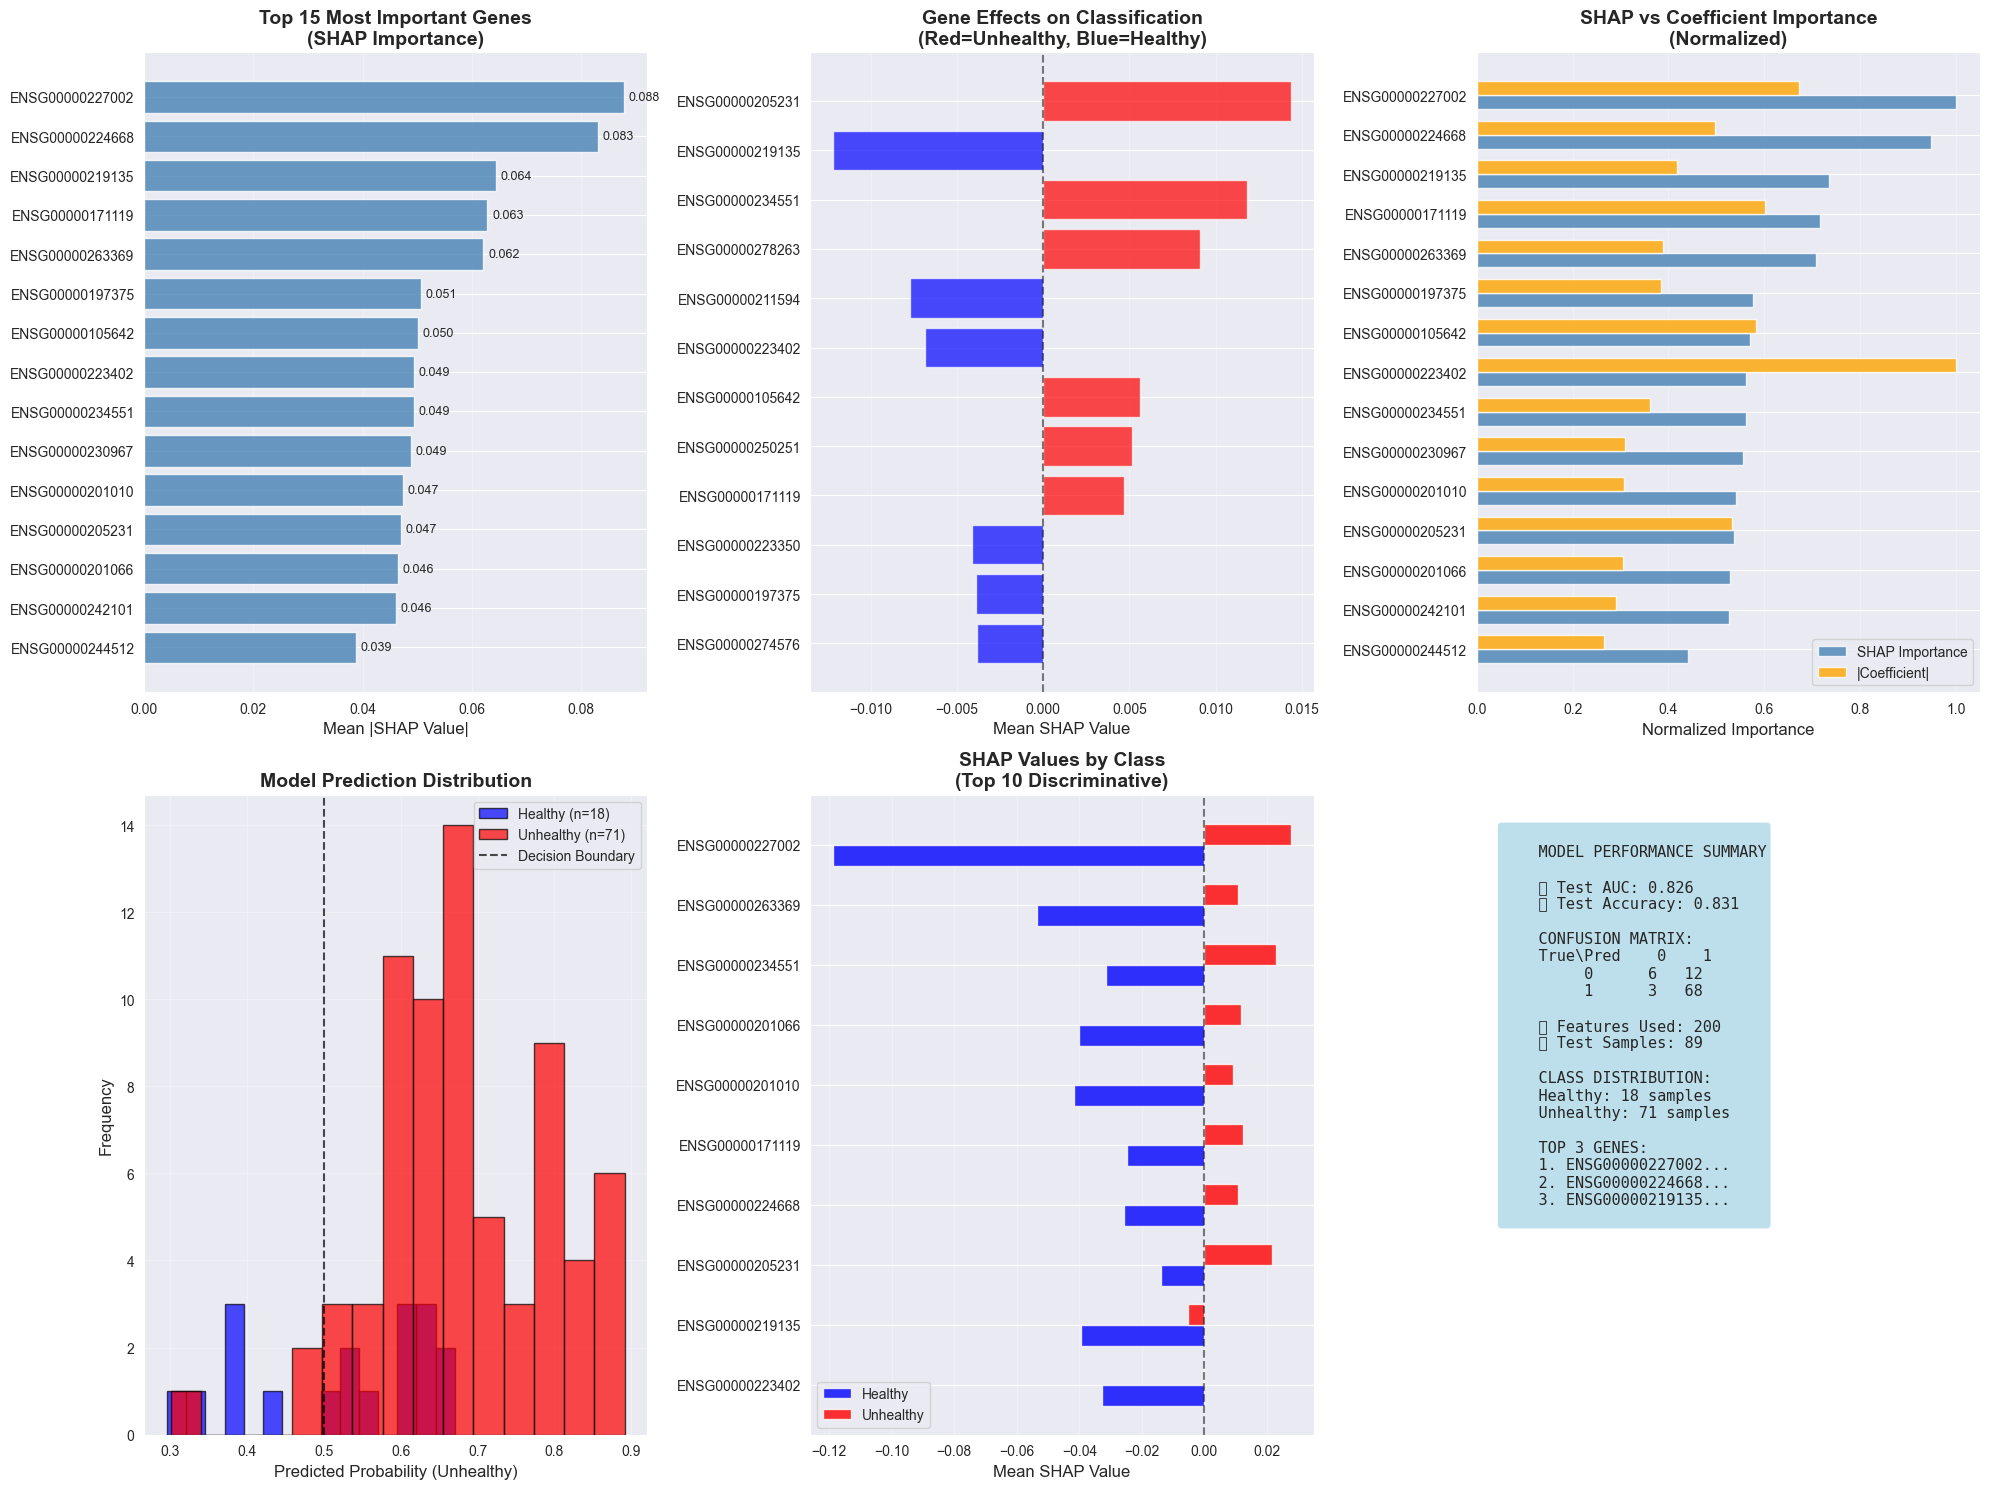


🧬 DETAILED GENE ANALYSIS:
----------------------------------------------------------------------

TOP 20 MOST IMPORTANT GENES:
                Gene  SHAP_Importance  SHAP_Effect Effect_Direction  \
101  ENSG00000227002           0.0878      -0.0019          Healthy   
94   ENSG00000224668           0.0832       0.0033        Unhealthy   
86   ENSG00000219135           0.0645      -0.0122          Healthy   
16   ENSG00000171119           0.0628       0.0047        Unhealthy   
177  ENSG00000263369           0.0621      -0.0023          Healthy   
26   ENSG00000197375           0.0506      -0.0039          Healthy   
4    ENSG00000105642           0.0501       0.0056        Unhealthy   
90   ENSG00000223402           0.0494      -0.0068          Healthy   
120  ENSG00000234551           0.0493       0.0118        Unhealthy   
111  ENSG00000230967           0.0489       0.0028        Unhealthy   
35   ENSG00000201010           0.0474      -0.0012          Healthy   
42   ENSG00000205231

In [58]:
=import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
import shap
import warnings
warnings.filterwarnings('ignore')

def clean_shap_analysis(X_clean, y_clean, n_features=200):
    """
    Clean, readable SHAP analysis with better visualizations
    """

    print("🔍 CLEAN SHAP EXPLAINABILITY ANALYSIS")
    print("="*50)

    # Prepare the data
    selector = SelectKBest(f_classif, k=n_features)
    X_selected = selector.fit_transform(X_clean, y_clean)
    selected_indices = selector.get_support(indices=True)
    selected_genes = X_clean.columns[selected_indices]

    X_selected_df = pd.DataFrame(X_selected, columns=selected_genes, index=X_clean.index)

    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(
        X_selected_df, y_clean, test_size=0.2, random_state=42, stratify=y_clean
    )

    # Train model
    model = Pipeline([
        ('scaler', StandardScaler()),
        ('lr', LogisticRegression(C=0.01, penalty='l2', solver='liblinear', random_state=42))
    ])
    model.fit(X_train, y_train)

    # SHAP analysis
    explainer = shap.LinearExplainer(model.named_steps['lr'],
                                   model.named_steps['scaler'].transform(X_train))
    X_test_scaled = model.named_steps['scaler'].transform(X_test)
    shap_values = explainer.shap_values(X_test_scaled)

    # Calculate importance metrics
    mean_shap_importance = np.mean(np.abs(shap_values), axis=0)
    mean_shap_values = np.mean(shap_values, axis=0)
    model_coefs = model.named_steps['lr'].coef_[0]

    print(f"✅ SHAP analysis completed for {len(selected_genes)} genes")
    print(f"📊 Model test accuracy: {model.score(X_test, y_test):.3f}")

    # Create clean visualizations
    fig = plt.figure(figsize=(20, 15))

    # 1. Top 15 Feature Importance (Clean Bar Plot)
    ax1 = plt.subplot(2, 3, 1)
    top_15_indices = np.argsort(mean_shap_importance)[-15:]
    top_15_importance = mean_shap_importance[top_15_indices]
    top_15_genes = [selected_genes[i] for i in top_15_indices]

    # Truncate gene names for readability
    gene_labels = [gene[:12] + '...' if len(gene) > 15 else gene for gene in top_15_genes]

    bars = ax1.barh(range(len(top_15_indices)), top_15_importance, color='steelblue', alpha=0.8)
    ax1.set_yticks(range(len(top_15_indices)))
    ax1.set_yticklabels(gene_labels, fontsize=10)
    ax1.set_xlabel('Mean |SHAP Value|', fontsize=12)
    ax1.set_title('Top 15 Most Important Genes\n(SHAP Importance)', fontsize=14, fontweight='bold')
    ax1.grid(axis='x', alpha=0.3)

    # Add value labels on bars
    for i, bar in enumerate(bars):
        width = bar.get_width()
        ax1.text(width + max(top_15_importance) * 0.01, bar.get_y() + bar.get_height()/2,
                f'{width:.3f}', ha='left', va='center', fontsize=9)

    # 2. Healthy vs Unhealthy Gene Effects
    ax2 = plt.subplot(2, 3, 2)

    # Get top genes by absolute mean SHAP value
    top_effect_indices = np.argsort(np.abs(mean_shap_values))[-12:]
    top_effect_values = mean_shap_values[top_effect_indices]
    top_effect_genes = [selected_genes[i] for i in top_effect_indices]

    # Truncate gene names
    effect_labels = [gene[:12] + '...' if len(gene) > 15 else gene for gene in top_effect_genes]

    # Color bars based on direction
    colors = ['red' if val > 0 else 'blue' for val in top_effect_values]

    bars2 = ax2.barh(range(len(top_effect_indices)), top_effect_values, color=colors, alpha=0.7)
    ax2.set_yticks(range(len(top_effect_indices)))
    ax2.set_yticklabels(effect_labels, fontsize=10)
    ax2.set_xlabel('Mean SHAP Value', fontsize=12)
    ax2.set_title('Gene Effects on Classification\n(Red=Unhealthy, Blue=Healthy)', fontsize=14, fontweight='bold')
    ax2.axvline(x=0, color='black', linestyle='--', alpha=0.5)
    ax2.grid(axis='x', alpha=0.3)

    # 3. SHAP vs Model Coefficients Comparison
    ax3 = plt.subplot(2, 3, 3)

    # Use top 15 by SHAP importance for comparison
    shap_vals = mean_shap_importance[top_15_indices]
    coef_vals = np.abs(model_coefs[top_15_indices])

    # Normalize for comparison
    shap_norm = shap_vals / np.max(shap_vals)
    coef_norm = coef_vals / np.max(coef_vals)

    x_pos = np.arange(len(top_15_indices))
    width = 0.35

    ax3.barh(x_pos - width/2, shap_norm, width, label='SHAP Importance', alpha=0.8, color='steelblue')
    ax3.barh(x_pos + width/2, coef_norm, width, label='|Coefficient|', alpha=0.8, color='orange')

    ax3.set_yticks(x_pos)
    ax3.set_yticklabels(gene_labels, fontsize=10)
    ax3.set_xlabel('Normalized Importance', fontsize=12)
    ax3.set_title('SHAP vs Coefficient Importance\n(Normalized)', fontsize=14, fontweight='bold')
    ax3.legend()
    ax3.grid(axis='x', alpha=0.3)

    # 4. Prediction Confidence Distribution
    ax4 = plt.subplot(2, 3, 4)

    y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Separate by true class
    healthy_probs = y_pred_proba[y_test == 0]
    unhealthy_probs = y_pred_proba[y_test == 1]

    ax4.hist(healthy_probs, bins=15, alpha=0.7, label=f'Healthy (n={len(healthy_probs)})',
            color='blue', edgecolor='black')
    ax4.hist(unhealthy_probs, bins=15, alpha=0.7, label=f'Unhealthy (n={len(unhealthy_probs)})',
            color='red', edgecolor='black')

    ax4.axvline(x=0.5, color='black', linestyle='--', alpha=0.7, label='Decision Boundary')
    ax4.set_xlabel('Predicted Probability (Unhealthy)', fontsize=12)
    ax4.set_ylabel('Frequency', fontsize=12)
    ax4.set_title('Model Prediction Distribution', fontsize=14, fontweight='bold')
    ax4.legend()
    ax4.grid(alpha=0.3)

    # 5. Feature Effect Magnitude by Class
    ax5 = plt.subplot(2, 3, 5)

    # Calculate mean SHAP by class for top genes
    healthy_mask = y_test == 0
    unhealthy_mask = y_test == 1

    if healthy_mask.sum() > 0 and unhealthy_mask.sum() > 0:
        healthy_shap = np.mean(shap_values[healthy_mask], axis=0)
        unhealthy_shap = np.mean(shap_values[unhealthy_mask], axis=0)

        # Get top 10 most different genes
        diff_values = np.abs(unhealthy_shap - healthy_shap)
        top_diff_indices = np.argsort(diff_values)[-10:]

        class_genes = [selected_genes[i][:12] + '...' if len(selected_genes[i]) > 15
                      else selected_genes[i] for i in top_diff_indices]

        x_pos = np.arange(len(top_diff_indices))
        width = 0.35

        ax5.barh(x_pos - width/2, healthy_shap[top_diff_indices], width,
                label='Healthy', alpha=0.8, color='blue')
        ax5.barh(x_pos + width/2, unhealthy_shap[top_diff_indices], width,
                label='Unhealthy', alpha=0.8, color='red')

        ax5.set_yticks(x_pos)
        ax5.set_yticklabels(class_genes, fontsize=10)
        ax5.set_xlabel('Mean SHAP Value', fontsize=12)
        ax5.set_title('SHAP Values by Class\n(Top 10 Discriminative)', fontsize=14, fontweight='bold')
        ax5.legend()
        ax5.axvline(x=0, color='black', linestyle='--', alpha=0.5)
        ax5.grid(axis='x', alpha=0.3)

    # 6. Model Performance Metrics
    ax6 = plt.subplot(2, 3, 6)
    ax6.axis('off')

    # Calculate detailed metrics
    from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix

    y_pred = model.predict(X_test)
    test_auc = roc_auc_score(y_test, y_pred_proba)
    cm = confusion_matrix(y_test, y_pred)

    # Create metrics text
    metrics_text = f"""
    MODEL PERFORMANCE SUMMARY

    🎯 Test AUC: {test_auc:.3f}
    📊 Test Accuracy: {model.score(X_test, y_test):.3f}

    CONFUSION MATRIX:
    True\\Pred    0    1
         0     {cm[0,0]:2d}   {cm[0,1]:2d}
         1     {cm[1,0]:2d}   {cm[1,1]:2d}

    🧬 Features Used: {n_features}
    📋 Test Samples: {len(y_test)}

    CLASS DISTRIBUTION:
    Healthy: {(y_test==0).sum()} samples
    Unhealthy: {(y_test==1).sum()} samples

    TOP 3 GENES:
    1. {selected_genes[top_15_indices[-1]][:20]}...
    2. {selected_genes[top_15_indices[-2]][:20]}...
    3. {selected_genes[top_15_indices[-3]][:20]}...
    """

    ax6.text(0.05, 0.95, metrics_text, transform=ax6.transAxes, fontsize=11,
            verticalalignment='top', fontfamily='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))

    plt.tight_layout()
    plt.show()

    # Detailed Gene Analysis Table
    print(f"\n🧬 DETAILED GENE ANALYSIS:")
    print("-" * 70)

    gene_analysis = pd.DataFrame({
        'Gene': selected_genes,
        'SHAP_Importance': mean_shap_importance,
        'SHAP_Effect': mean_shap_values,
        'Effect_Direction': ['Unhealthy' if x > 0 else 'Healthy' for x in mean_shap_values],
        'Coefficient': model_coefs,
        'F_Score': selector.scores_[selected_indices]
    }).sort_values('SHAP_Importance', ascending=False)

    print("\nTOP 20 MOST IMPORTANT GENES:")
    print(gene_analysis.head(20).round(4))

    # Summary insights
    print(f"\n💡 KEY INSIGHTS:")
    print("-" * 30)

    top_healthy = gene_analysis[gene_analysis['Effect_Direction'] == 'Healthy'].head(5)
    top_unhealthy = gene_analysis[gene_analysis['Effect_Direction'] == 'Unhealthy'].head(5)

    print(f"\n🔵 TOP HEALTHY INDICATORS:")
    for _, gene in top_healthy.iterrows():
        print(f"   • {gene['Gene'][:25]:<25} (SHAP: {gene['SHAP_Effect']:.3f})")

    print(f"\n🔴 TOP UNHEALTHY INDICATORS:")
    for _, gene in top_unhealthy.iterrows():
        print(f"   • {gene['Gene'][:25]:<25} (SHAP: {gene['SHAP_Effect']:.3f})")

    return {
        'model': model,
        'shap_values': shap_values,
        'selected_genes': selected_genes,
        'gene_analysis': gene_analysis,
        'test_auc': test_auc,
        'X_test': X_test,
        'y_test': y_test
    }

# Usage:
if __name__ == "__main__":
    clean_results = clean_shap_analysis(X_clean, y_clean, n_features=200)

    print(f"\n✅ Clean SHAP analysis completed!")
    print(f"🎯 Final Test AUC: {clean_results['test_auc']:.3f}")
    print(f"🧬 Most important gene: {clean_results['gene_analysis'].iloc[0]['Gene']}")